In [42]:
#import lightgbm as lgb

In [43]:
#!pip install  --no-cache-dir  imblearn shap  lazypredict


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
import sklearn

sklearn.__version__

'1.4.2'

In [4]:
#import sweetviz as sv
import pandas as pd
#import dtale
#import numpy as np
#from sdmetrics.reports.multi_table import QualityReport
%matplotlib inline


import os
import json

#from pandas.io.json import json_normalize
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
#import umap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

from sklearn.cluster import KMeans
#from kmodes.kprototypes import KPrototypes


from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import seaborn as sns
from sklearn.metrics import PrecisionRecallDisplay

#from pycaret.anomaly import *

/opt/miniconda3/envs/triage_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:


df_triage = pd.read_csv("../data/Triage.csv",sep=';'
                    #,parse_dates=['innDatoTid','utDatoTid'],
  )
df_triage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205488 entries, 0 to 205487
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Phtriage           96061 non-null   float64
 1   Htriage            205487 non-null  float64
 2   Dischgto           205412 non-null  object 
 3   Dischhome          205488 non-null  int64  
 4   DischICU           205488 non-null  int64  
 5   EMRGgroup          205484 non-null  object 
 6   Time_in            205487 non-null  object 
 7   Time_out           205428 non-null  object 
 8   EDLOS              205359 non-null  float64
 9   Kjonn              205480 non-null  object 
 10  InICD10-code       157814 non-null  object 
 11  InICD10-chapter    205488 non-null  object 
 12  Aar                205487 non-null  float64
 13  Mnd                205487 non-null  float64
 14  DOW                205487 non-null  object 
 15  Shift              196066 non-null  object 
 16  np

## Feature enginering

In [6]:
df_triage_t = df_triage.copy()

### Select the variables

In [7]:
features = ['Htriage' ,
           #   'Dischgto'
             'Dischhome',
            'DischICU',
            'EMRGgroup',
        'Kjonn', 'InICD10-chapter',
          #  'Aar' correlated to triagestmt
            'Mnd'
       ,'DOW', 'Shift',# 'nprDiagn', 'Out_ICD10-chapter',
            'AgeGrp',
            '24hmrt',
      # '7dmrt', 30dmrt,
            'Triagestm',
            'Time_in_h'
      # ,'Time_in_m'#, 'Time_out_h', 'Time_out_m'
           ]
categorical_features =[ 'Htriage'
                       # 'Dischgto'
                       , 'Dischhome'#, 'DischICU'
                        'EMRGgroup',
        'Kjonn',  'InICD10-chapter',
                 #      'Aar'
                        'Mnd',
       'DOW', 'Shift',# 'nprDiagn',# 'Out_ICD10-chapter',
                       'AgeGrp',
                       '24hmrt',
      # '7dmrt',
       '30dmrt',
                       'Triagestm',
     # 'Time_in_h'#, 'Time_in_m',
       #'Time_out_h', 'Time_out_m'
                      ]

nominal_features=[#'Dischgto',
                  #'Dischhome'#, 'DischICU'
                  'EMRGgroup',
        'Kjonn',  'InICD10-chapter',
       'DOW', 'Shift',# 'nprDiagn', 'Out_ICD10-chapter',
    '24hmrt'
     #  ,'7dmrt', '30dmrt'
]
ordinal_features=[ 'Htriage',
          #        'Aar'
                   'Mnd',
      'Age', 'Triagestm',
     # 'Time_in_h'#, 'Time_in_m',
       #'Time_out_h', 'Time_out_m'
                 ]


## Imputation

In [8]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import SimpleImputer

In [9]:

import numpy as np
# Setting the random_state argument for reproducibility

imputer = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='missing')
#imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
#imputer = imp_constant(random_state=42)
imputer.fit(df_triage_t[nominal_features])
df_triage_t[nominal_features] = imputer.transform(pd.DataFrame(df_triage_t, columns=nominal_features))

imputer = IterativeImputer(BayesianRidge())
imputer.fit(df_triage_t[ordinal_features])
df_triage_t[ordinal_features] = imputer.transform(pd.DataFrame(df_triage_t, columns=ordinal_features))





### Select population of undertriaged/overtriaged patients

In [10]:
#Number of undertriaged patients 30d alive
#df_triage_t = df_triage_t.loc[(df_triage_t['30dmrt']==1) & (df_triage_t.DischICU==1)]

## Undertriage
df_triage_t = df_triage_t.loc[df_triage_t.Mrt_AND_OR_ICU==1]

## Ovrtriage
#df_triage_t = df_triage_t.loc[df_triage_t.Dischhome==1]

df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9784 entries, 35 to 205185
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Phtriage           5238 non-null   float64
 1   Htriage            9784 non-null   float64
 2   Dischgto           9784 non-null   object 
 3   Dischhome          9784 non-null   int64  
 4   DischICU           9784 non-null   int64  
 5   EMRGgroup          9784 non-null   object 
 6   Time_in            9784 non-null   object 
 7   Time_out           9783 non-null   object 
 8   EDLOS              9773 non-null   float64
 9   Kjonn              9784 non-null   object 
 10  InICD10-code       8177 non-null   object 
 11  InICD10-chapter    9784 non-null   object 
 12  Aar                9784 non-null   float64
 13  Mnd                9784 non-null   float64
 14  DOW                9784 non-null   object 
 15  Shift              9784 non-null   object 
 16  nprDiagn           9337 no

## Transform Features

### Emergency Group


<Axes: xlabel='EMRGgroup'>

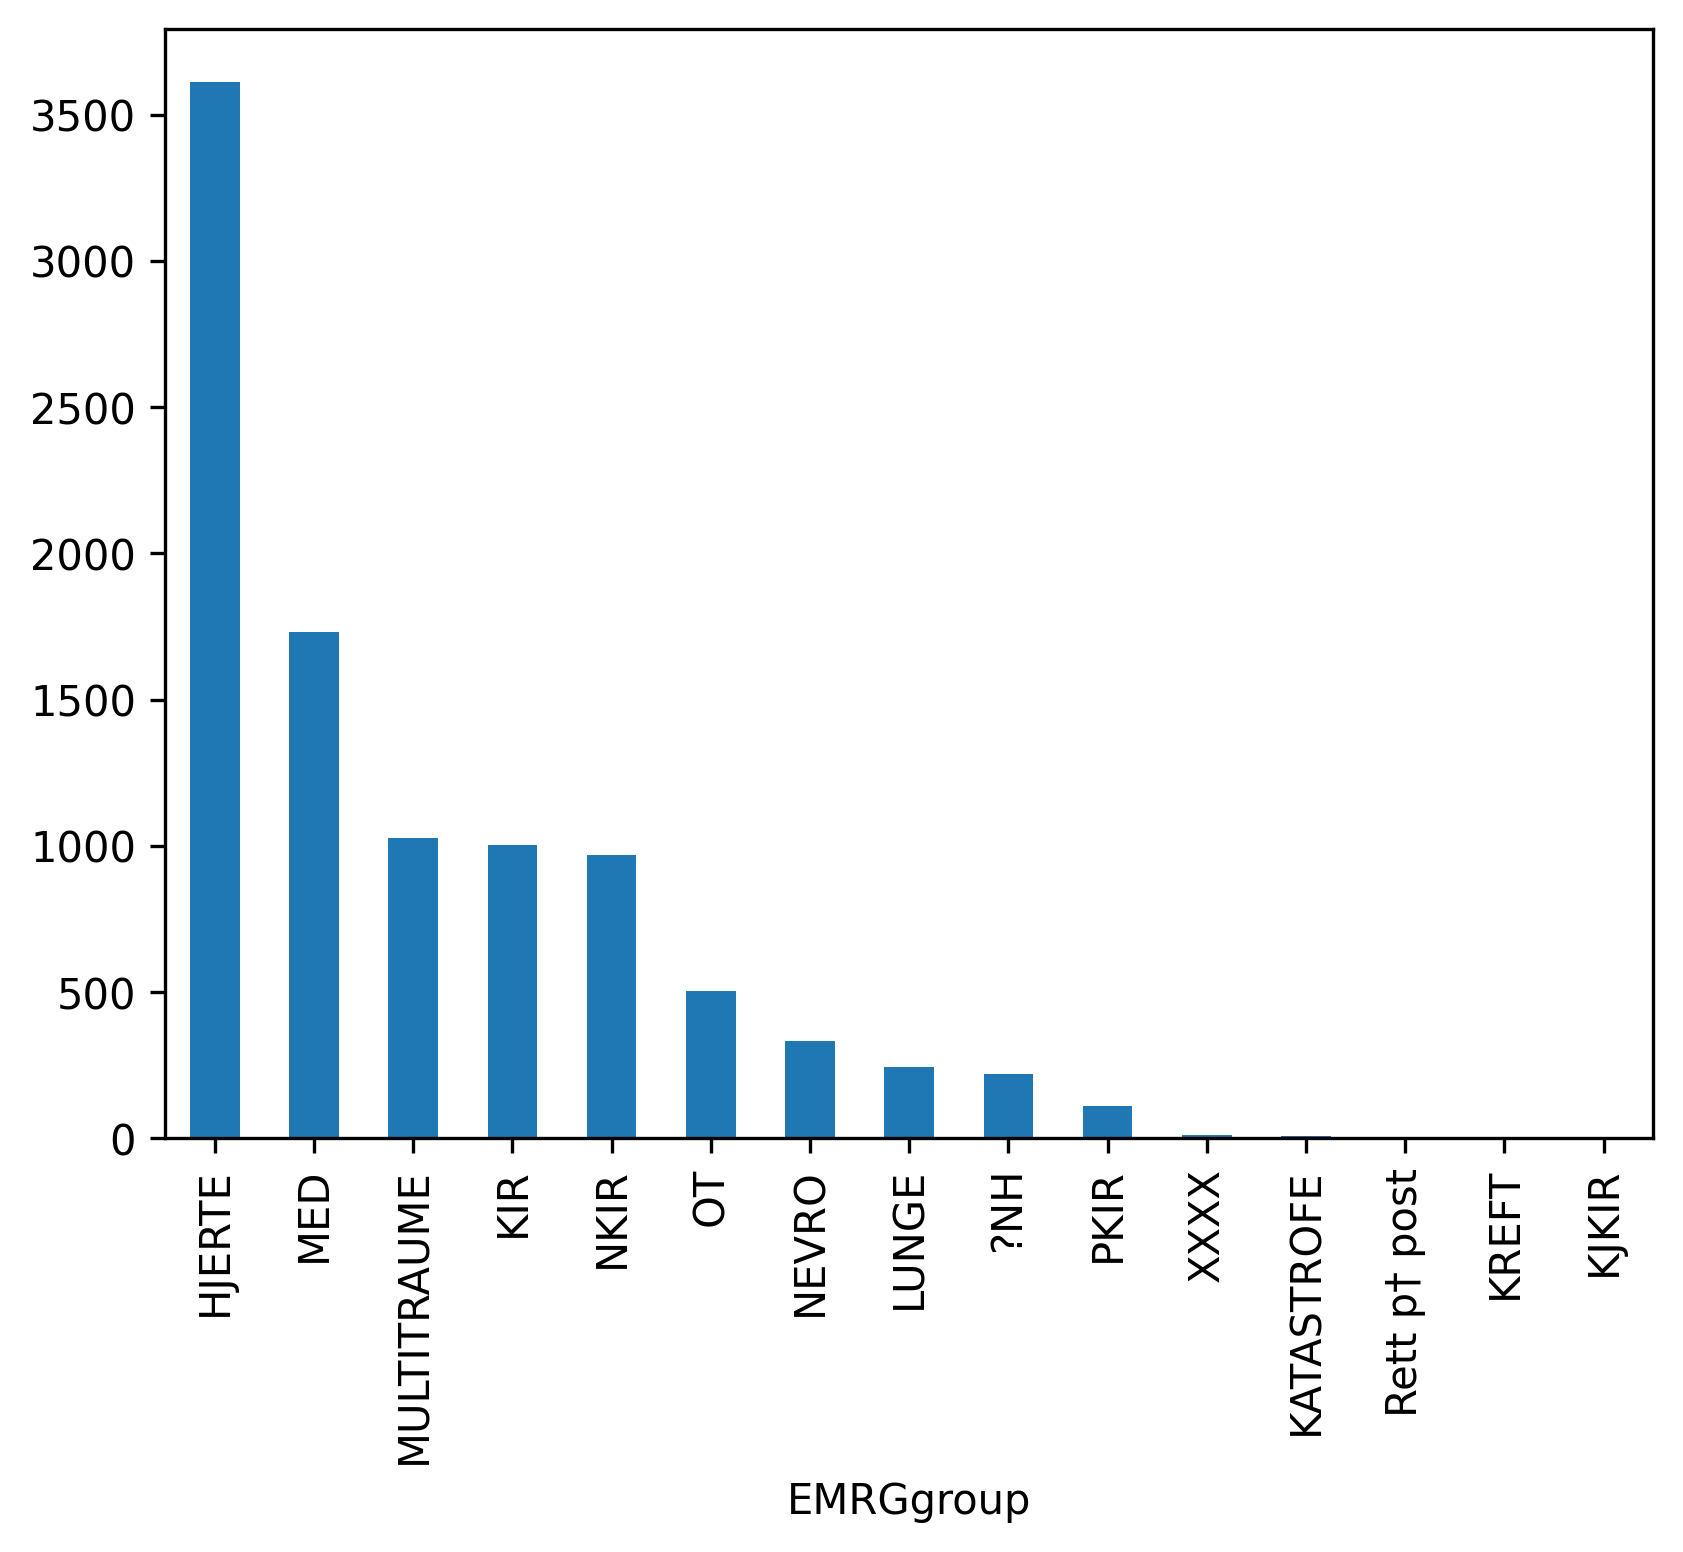

In [11]:
df_triage_t["EMRGgroup"].value_counts().plot(kind='bar')

In [12]:
emr_map= {'HJERTE'          :'Cardiology',
'MED'             :'Medical',
'MULTITRAUME'     :'Trauma',
'KIR'             :'Surgery',
'NKIR'             : 'Neurosurger' ,
'OT'               : 'Orthopedics',
 'ORT': 'Orthopedics',
'NEVRO'            :'Neurology',
'LUNGE'           : 'Medical',
'?NH'              :'Otolaryngology',
 'ØNH'              :'Otolaryngology',
'PKIR'             :'Plastic surgery',
'XXXX'              :'NA',
'KATASTROFE'         :'Other',
'Rett p† post'       :'Other',
'KREFT'              :'Oncology',
'KJKIR':'Surgery'     }

<Axes: xlabel='EMRGgroup'>

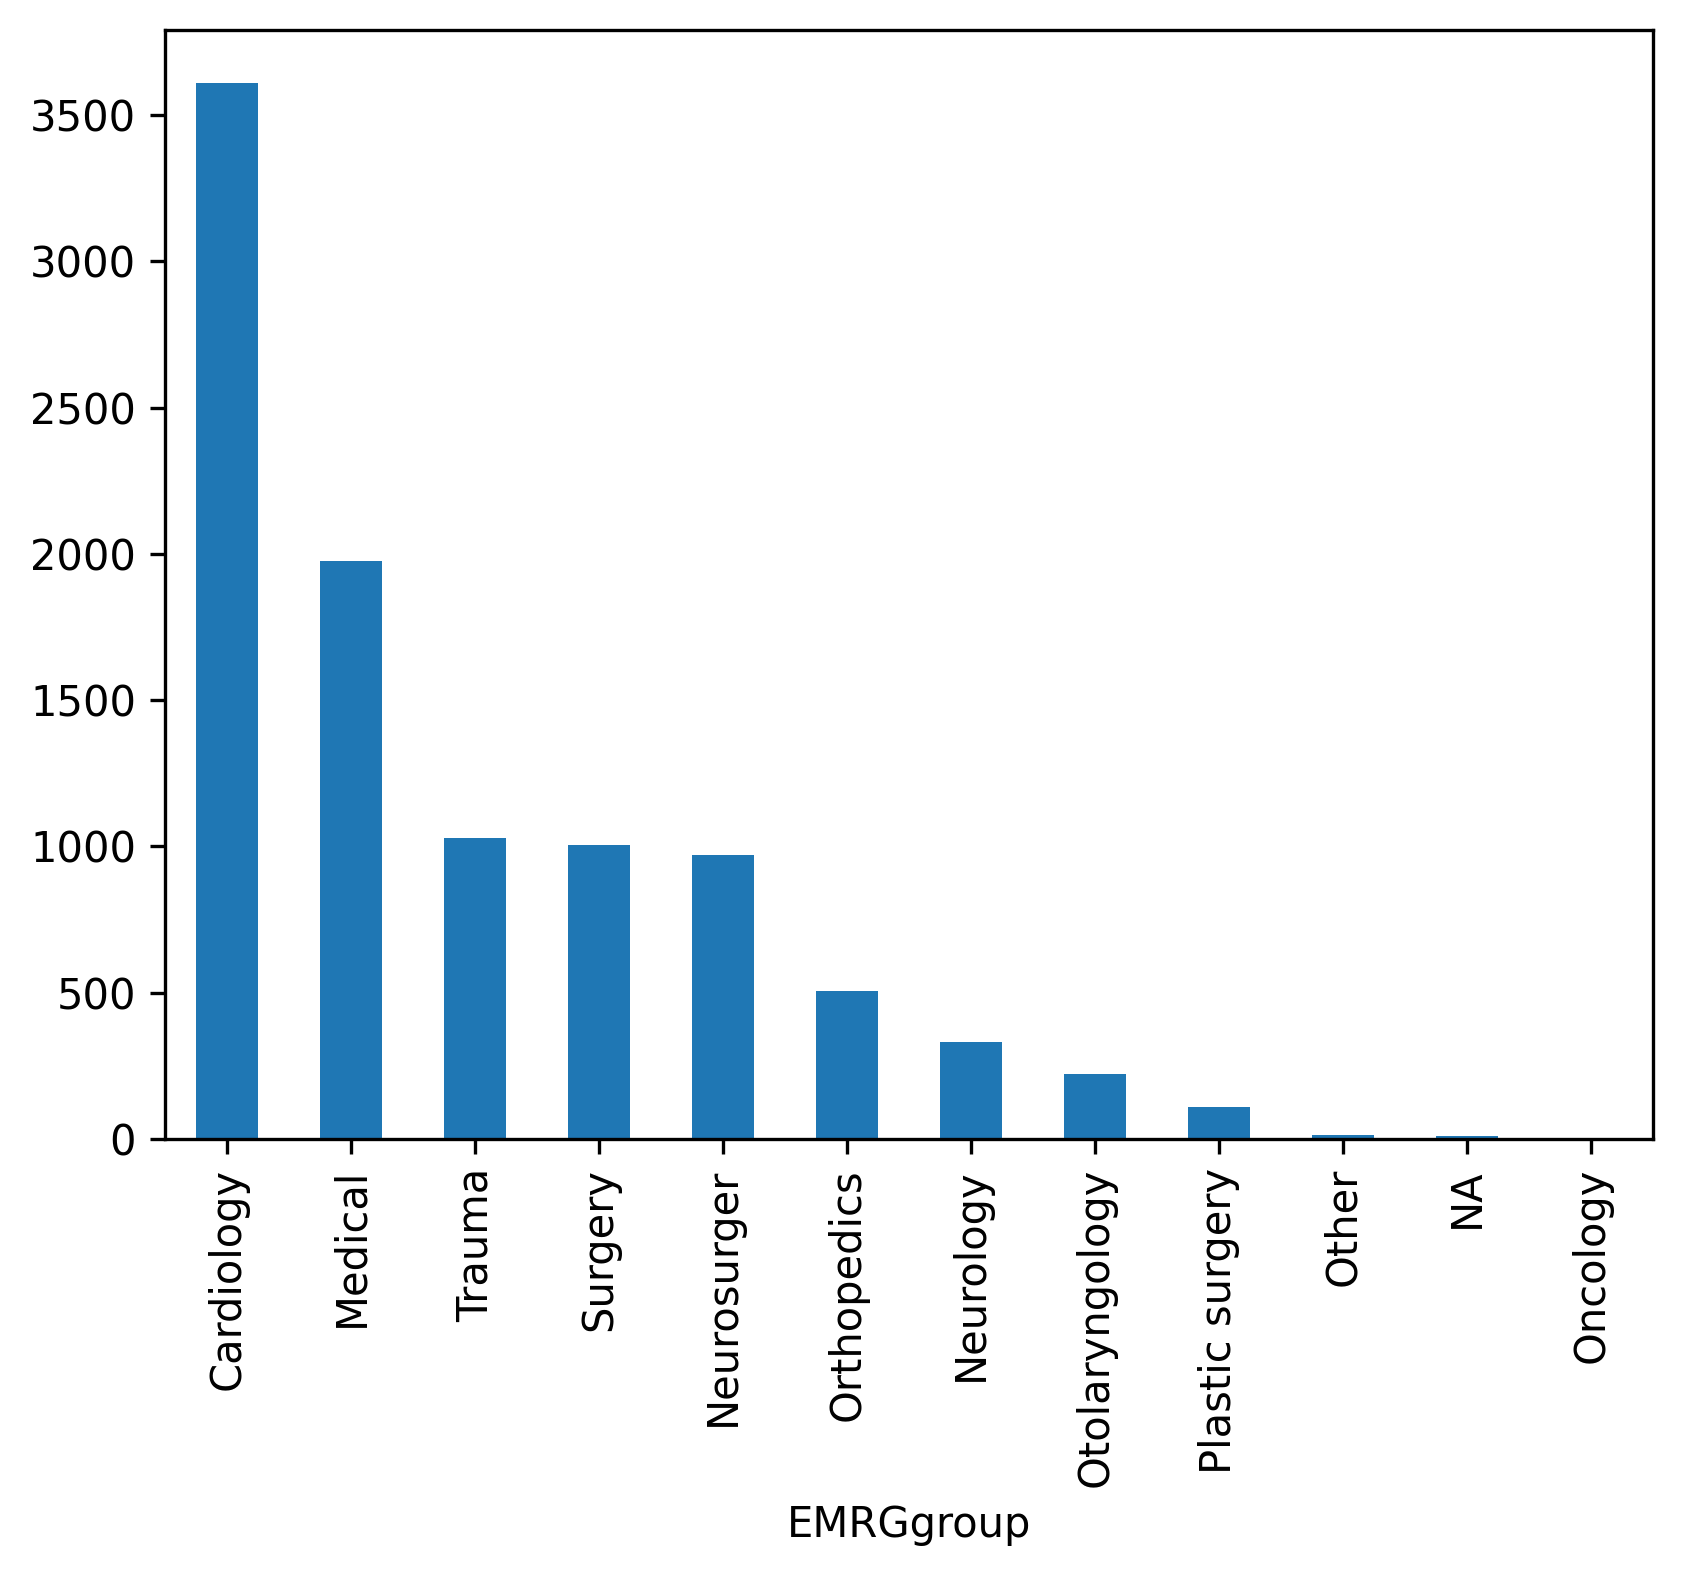

In [13]:

df_triage_t["EMRGgroup"] = df_triage_t.EMRGgroup.map(emr_map)
df_triage_t["EMRGgroup"].value_counts().plot(kind='bar')

###  Age

<Axes: >

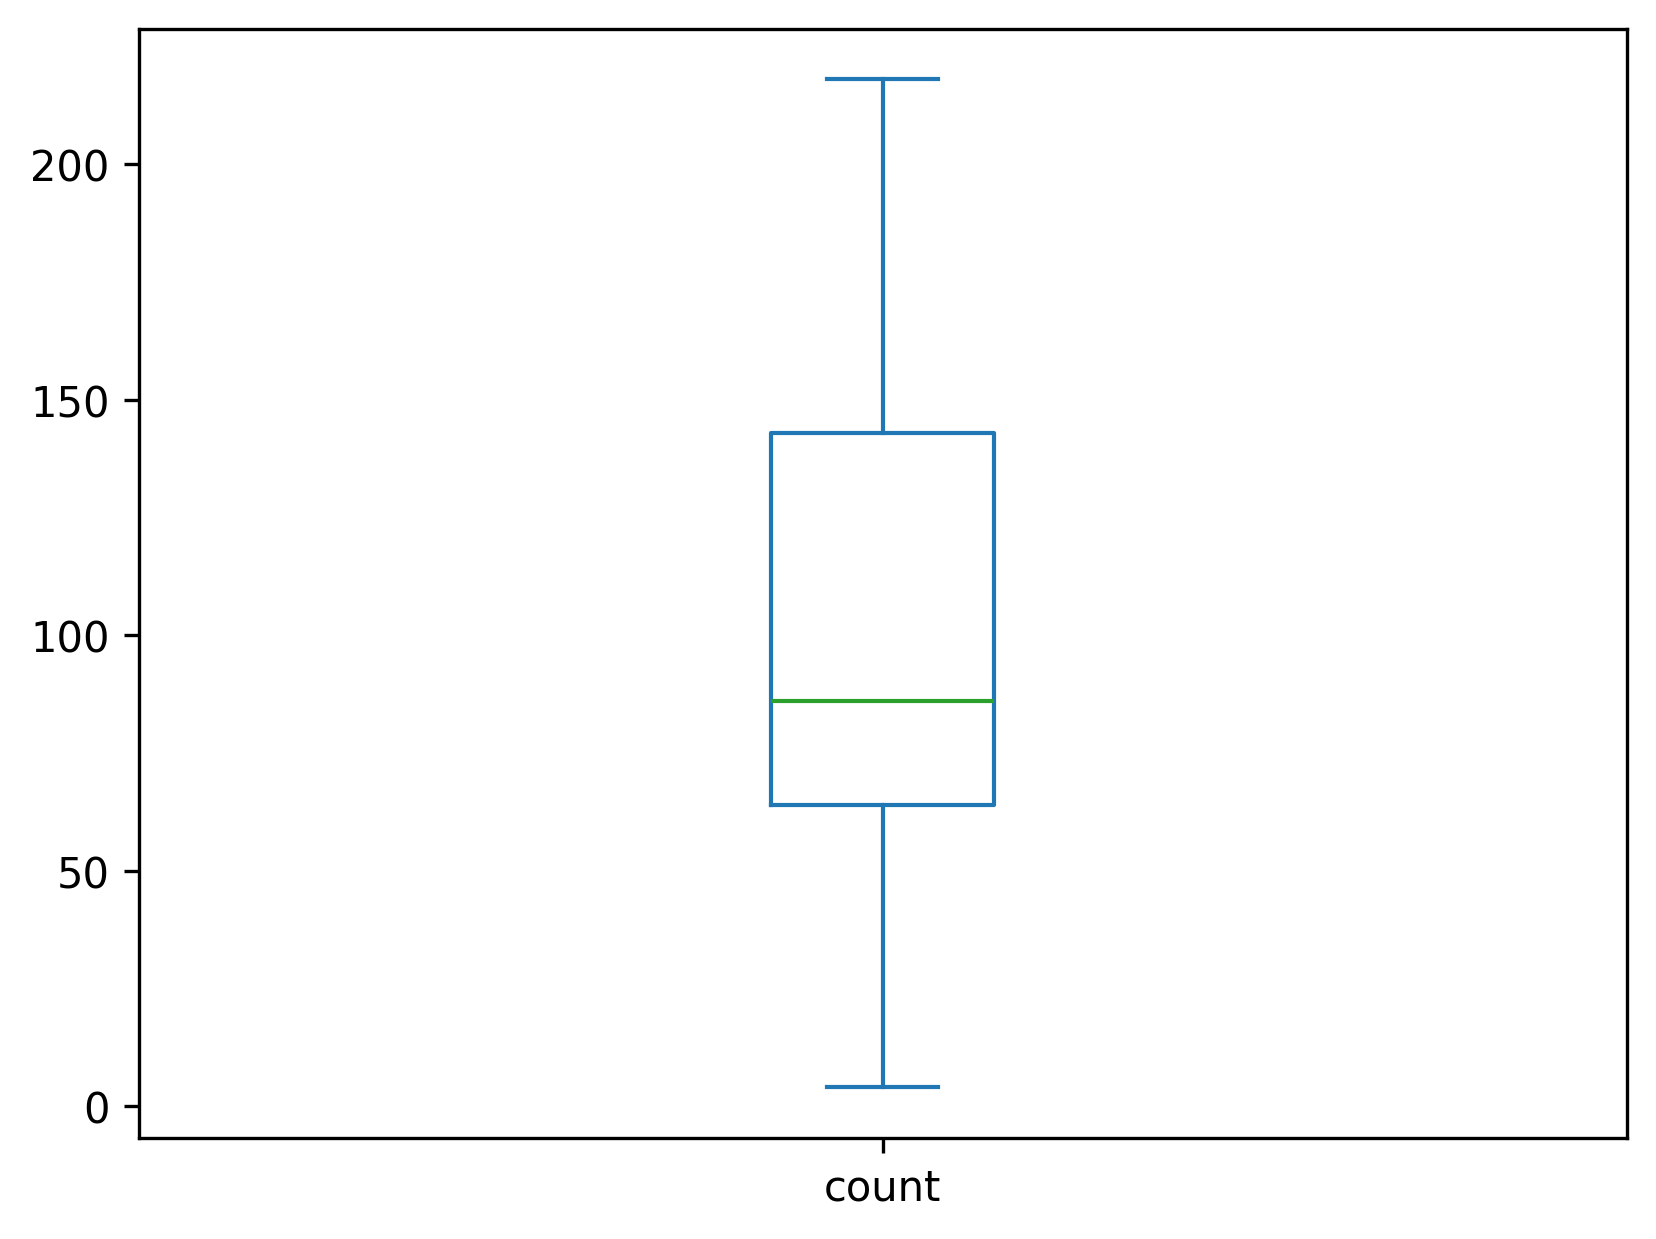

In [14]:
df_triage_t['Age'].value_counts().plot(kind='box')

<Axes: xlabel='AgeGrp'>

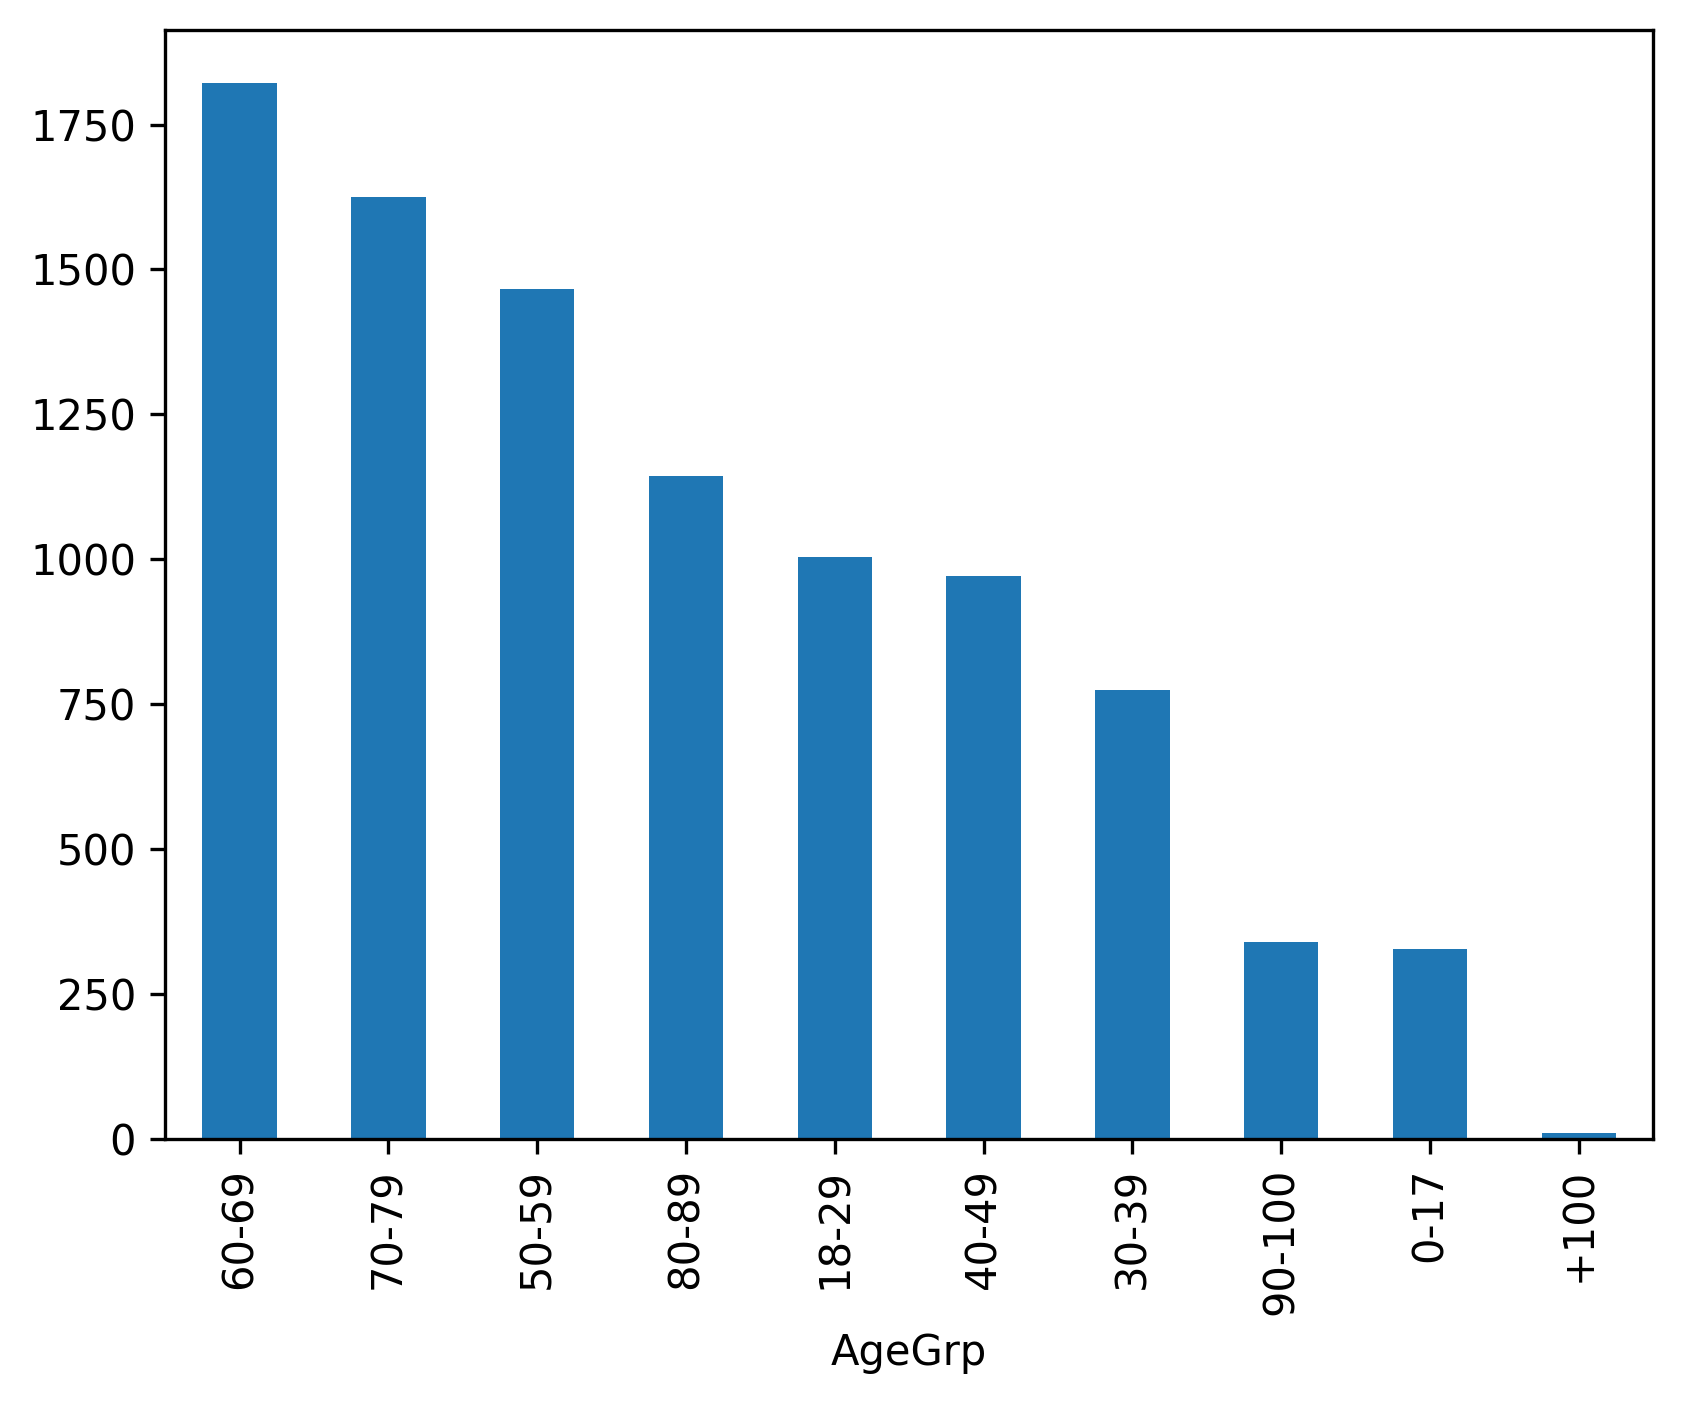

In [15]:
df_triage_t.Age= df_triage_t.Age.astype(float).astype(int)
#df_triage_t=df_triage_t.loc[df_triage_t.Age>=18]
bins = [10,18,30,40,50,60,70,80,90,100,200]
labels = ['0-17','18-29', '30-39','40-49','50-59','60-69','70-79','80-89','90-100','+100']
df_triage_t['AgeGrp'] = pd.cut(df_triage_t.Age, bins, labels = labels,right=False)
#df_triage_t["AgeGrp"] = df_triage_t.AgeGrp.map({'0-12':0,'13-17':1, '20-64':2, '65+':3})
#df_triage_t["AgeGrpDesc"] = df_triage_t.AgeGrp.map({'0-12':'Children','13-17':'Teen', '18-64':'Adult', '65+':'Older'})
df_triage_t['AgeGrp'].value_counts().plot(kind='bar')

### Triage score

<Axes: xlabel='Htriage'>

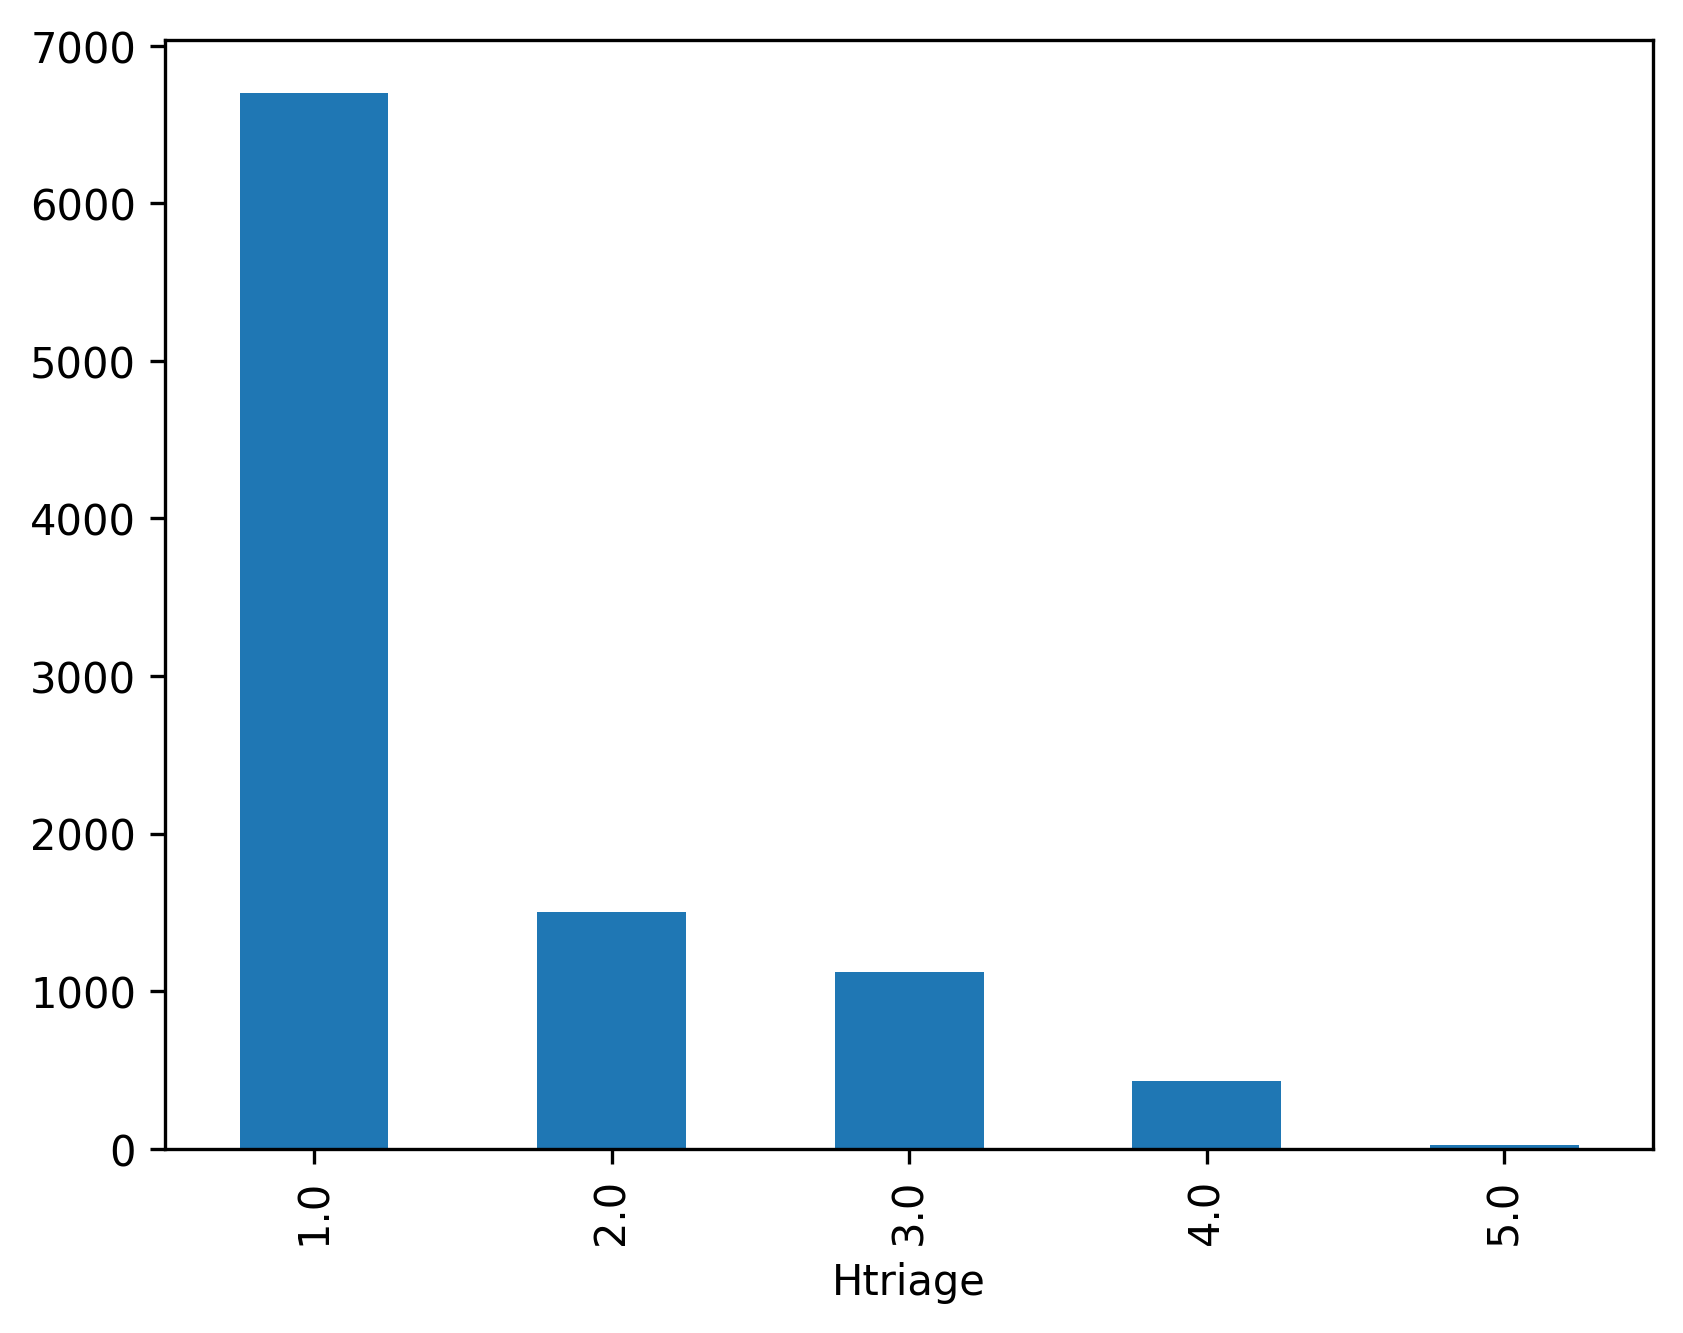

In [16]:
df_triage_t['Htriage'].value_counts().plot(kind='bar')

<Axes: xlabel='HtriageGrpDesc'>

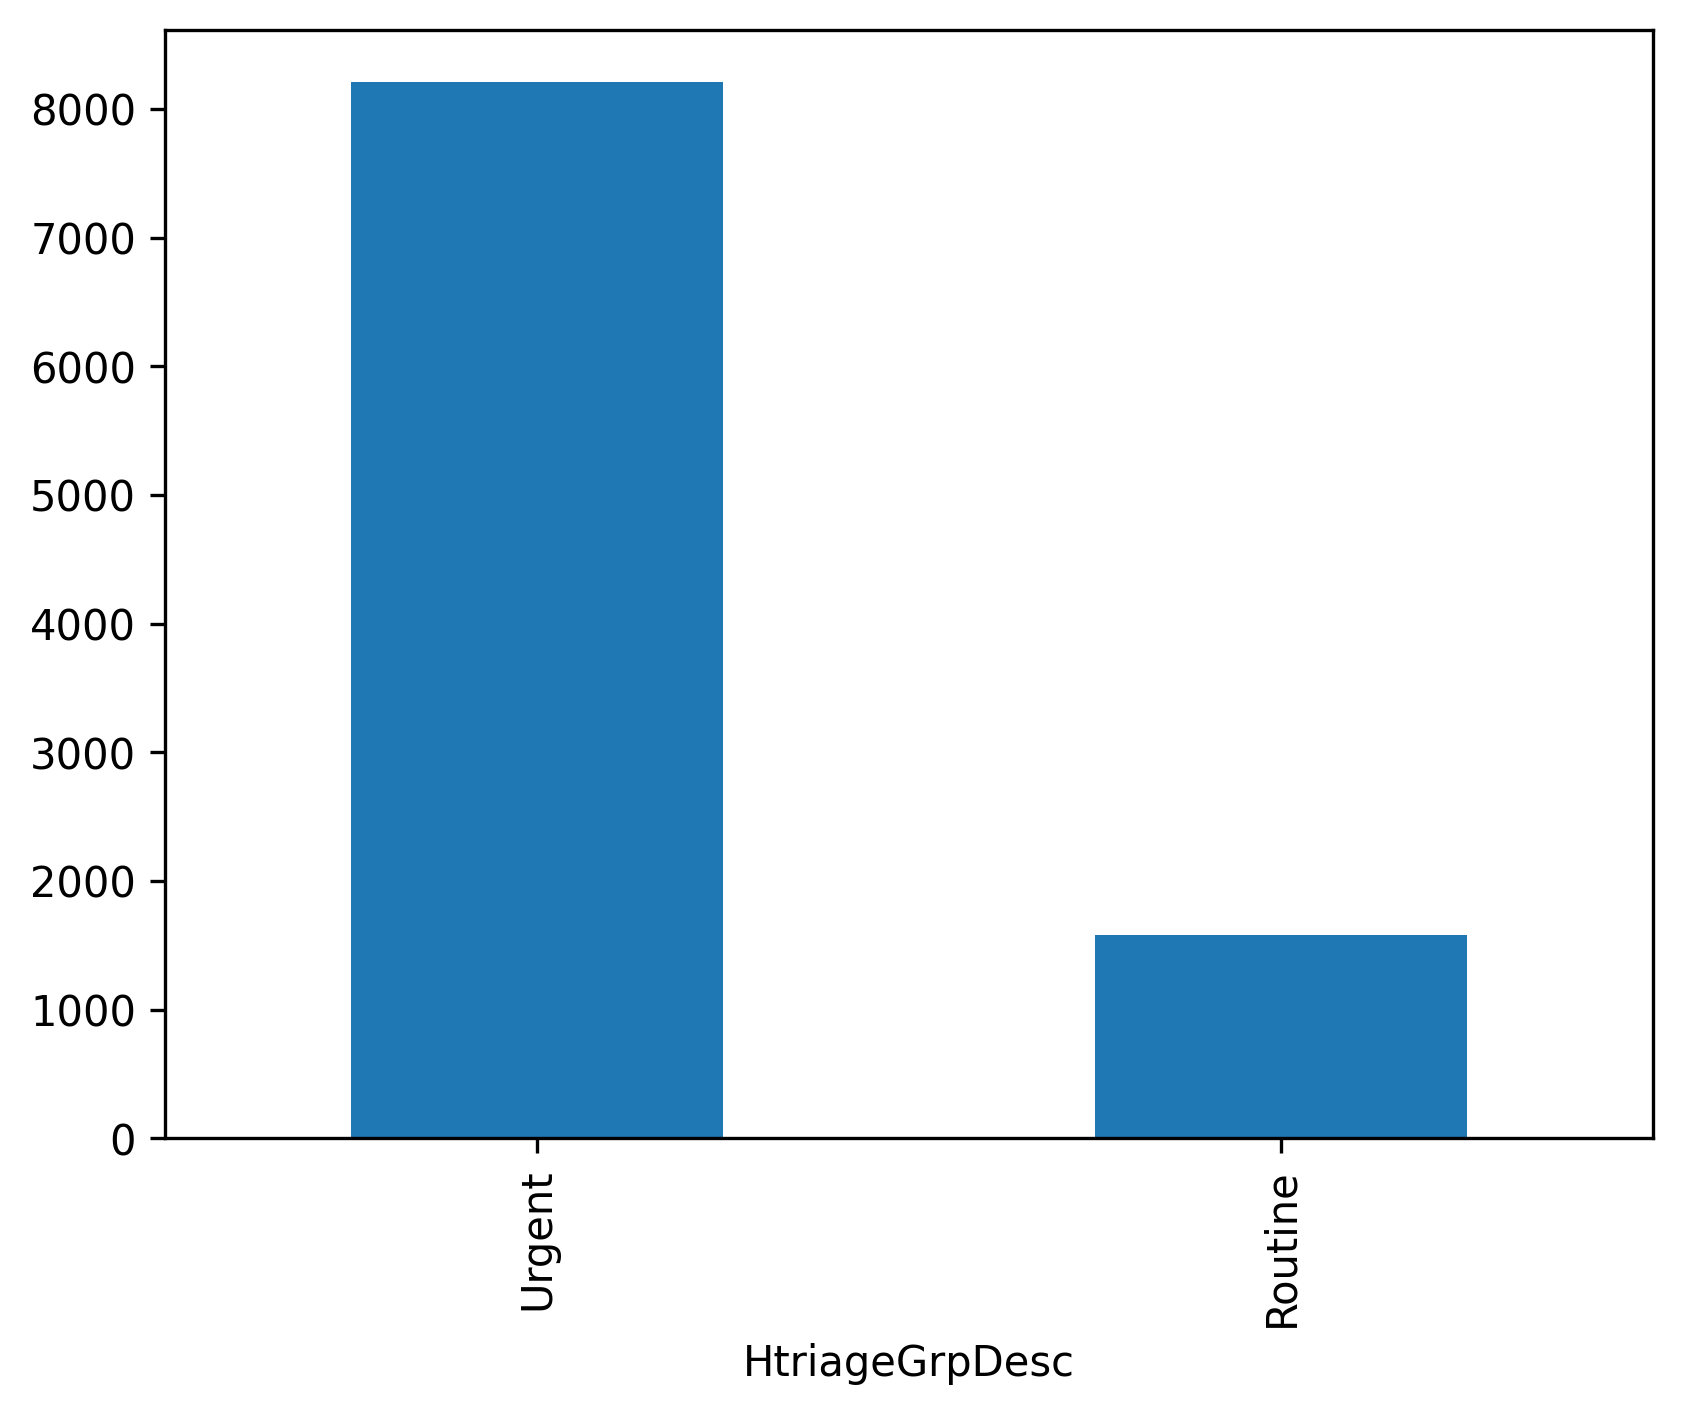

In [17]:
df_triage_t['Htriage']= df_triage_t['Htriage'].astype(float).astype(int)
df_triage_t['HtriageGrp'] = np.where(df_triage_t['Htriage']<3,0,1)
df_triage_t['HtriageGrpDesc'] = np.where(df_triage_t['Htriage']<3,"Urgent","Routine")
df_triage_t['HtriageGrpDesc'].value_counts().plot(kind='bar')

###  Shift

<Axes: xlabel='Shift'>

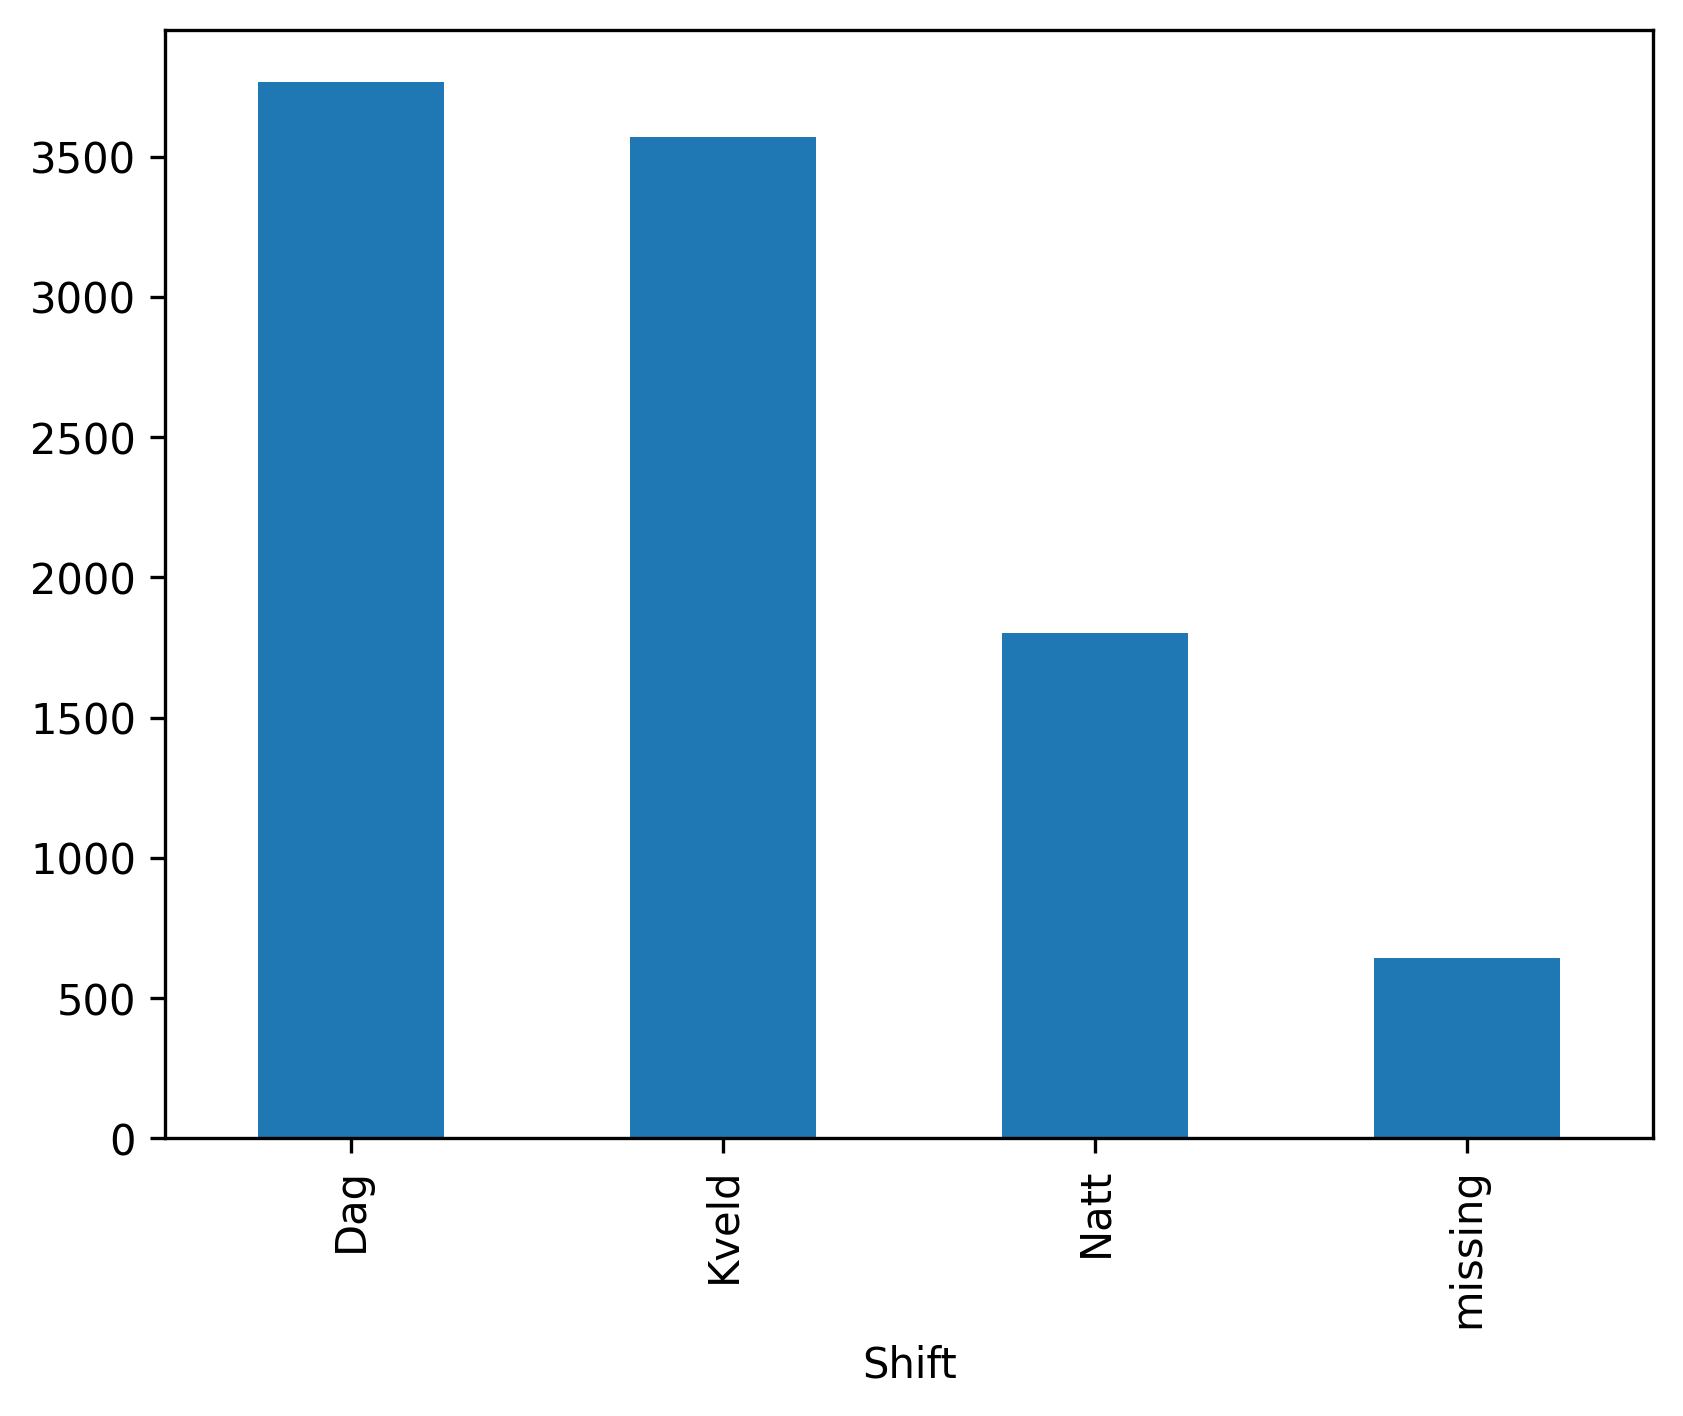

In [18]:
df_triage_t["Shift"].value_counts().plot(kind='bar')

<Axes: xlabel='Shift'>

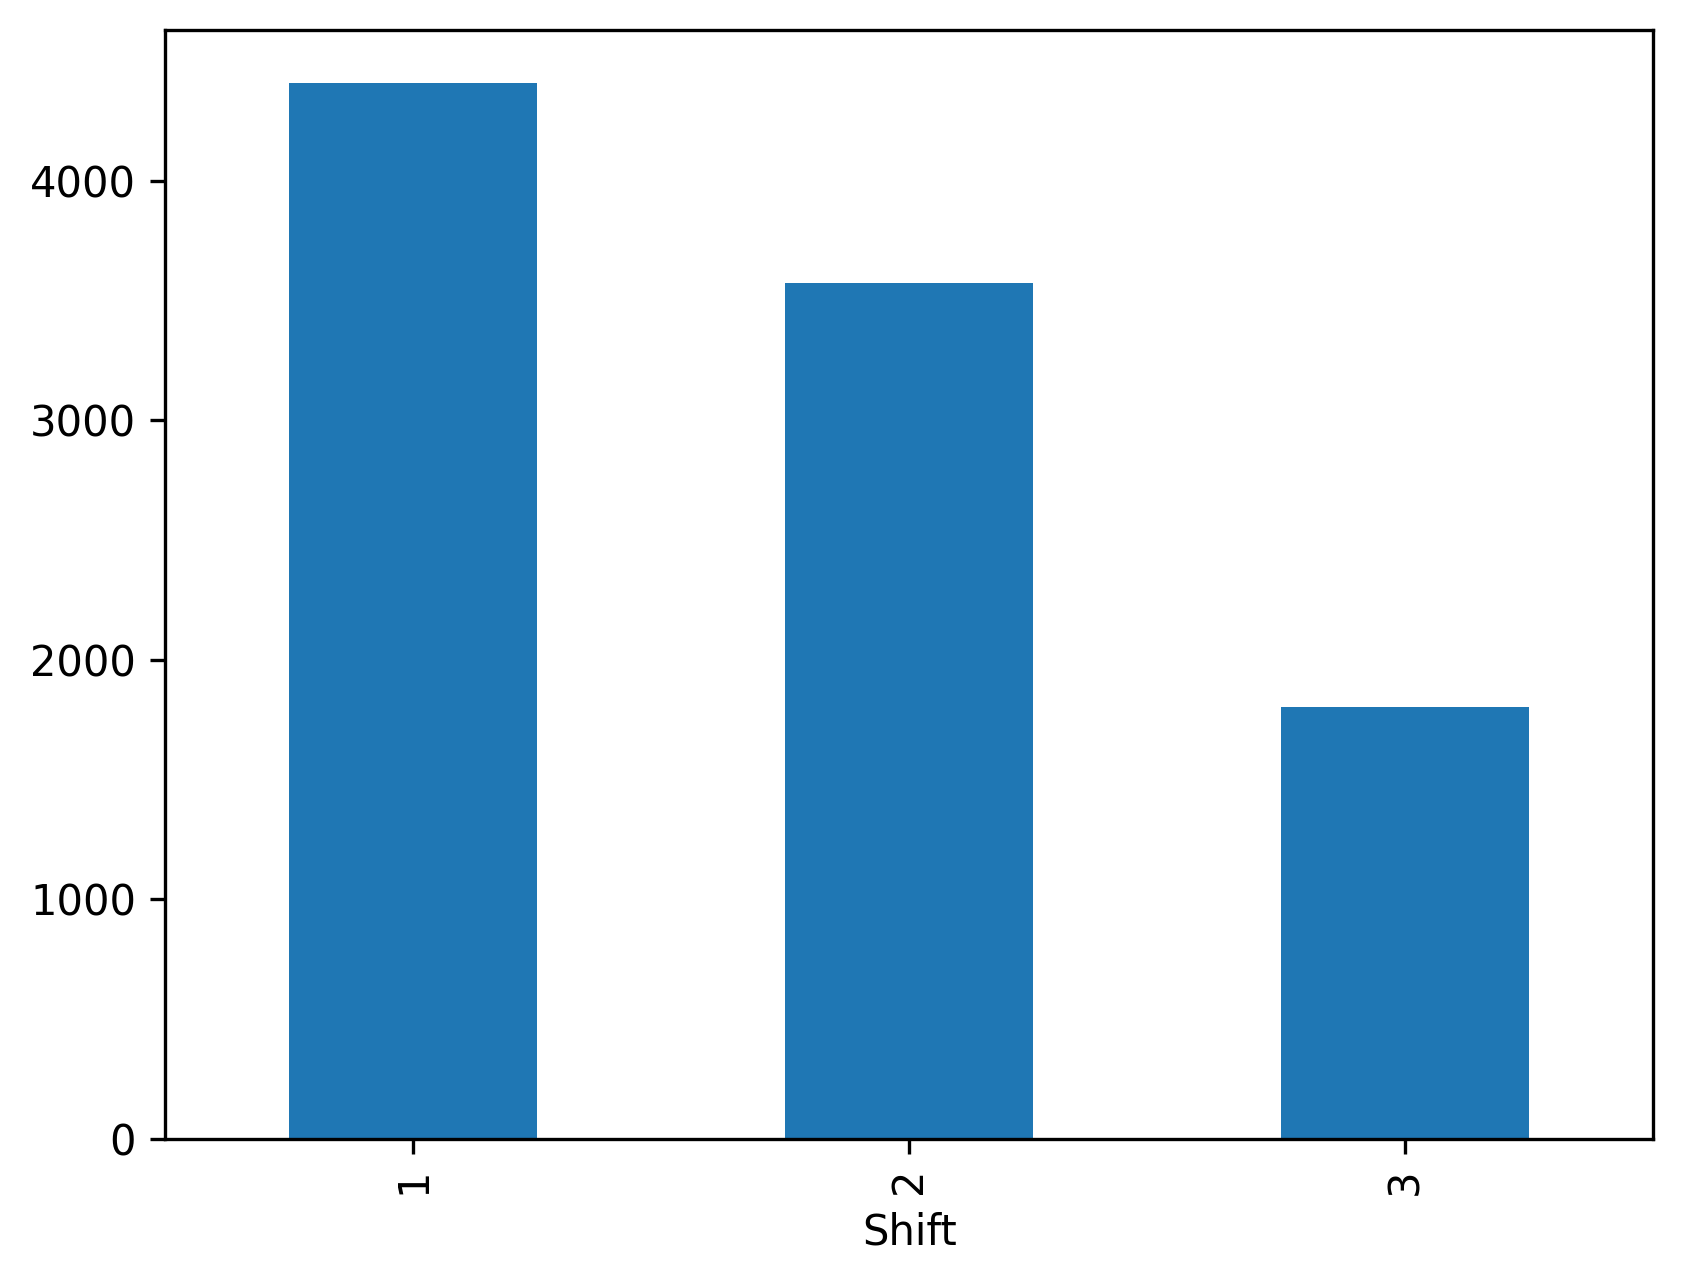

In [19]:

df_triage_t["Shift"] = df_triage_t.Shift.map({'Dag':1,'Kveld':2,'Natt':3,'missing':1})
df_triage_t["Shift"].value_counts().plot(kind='bar')

### Transform Mnd

<Axes: xlabel='Mnd'>

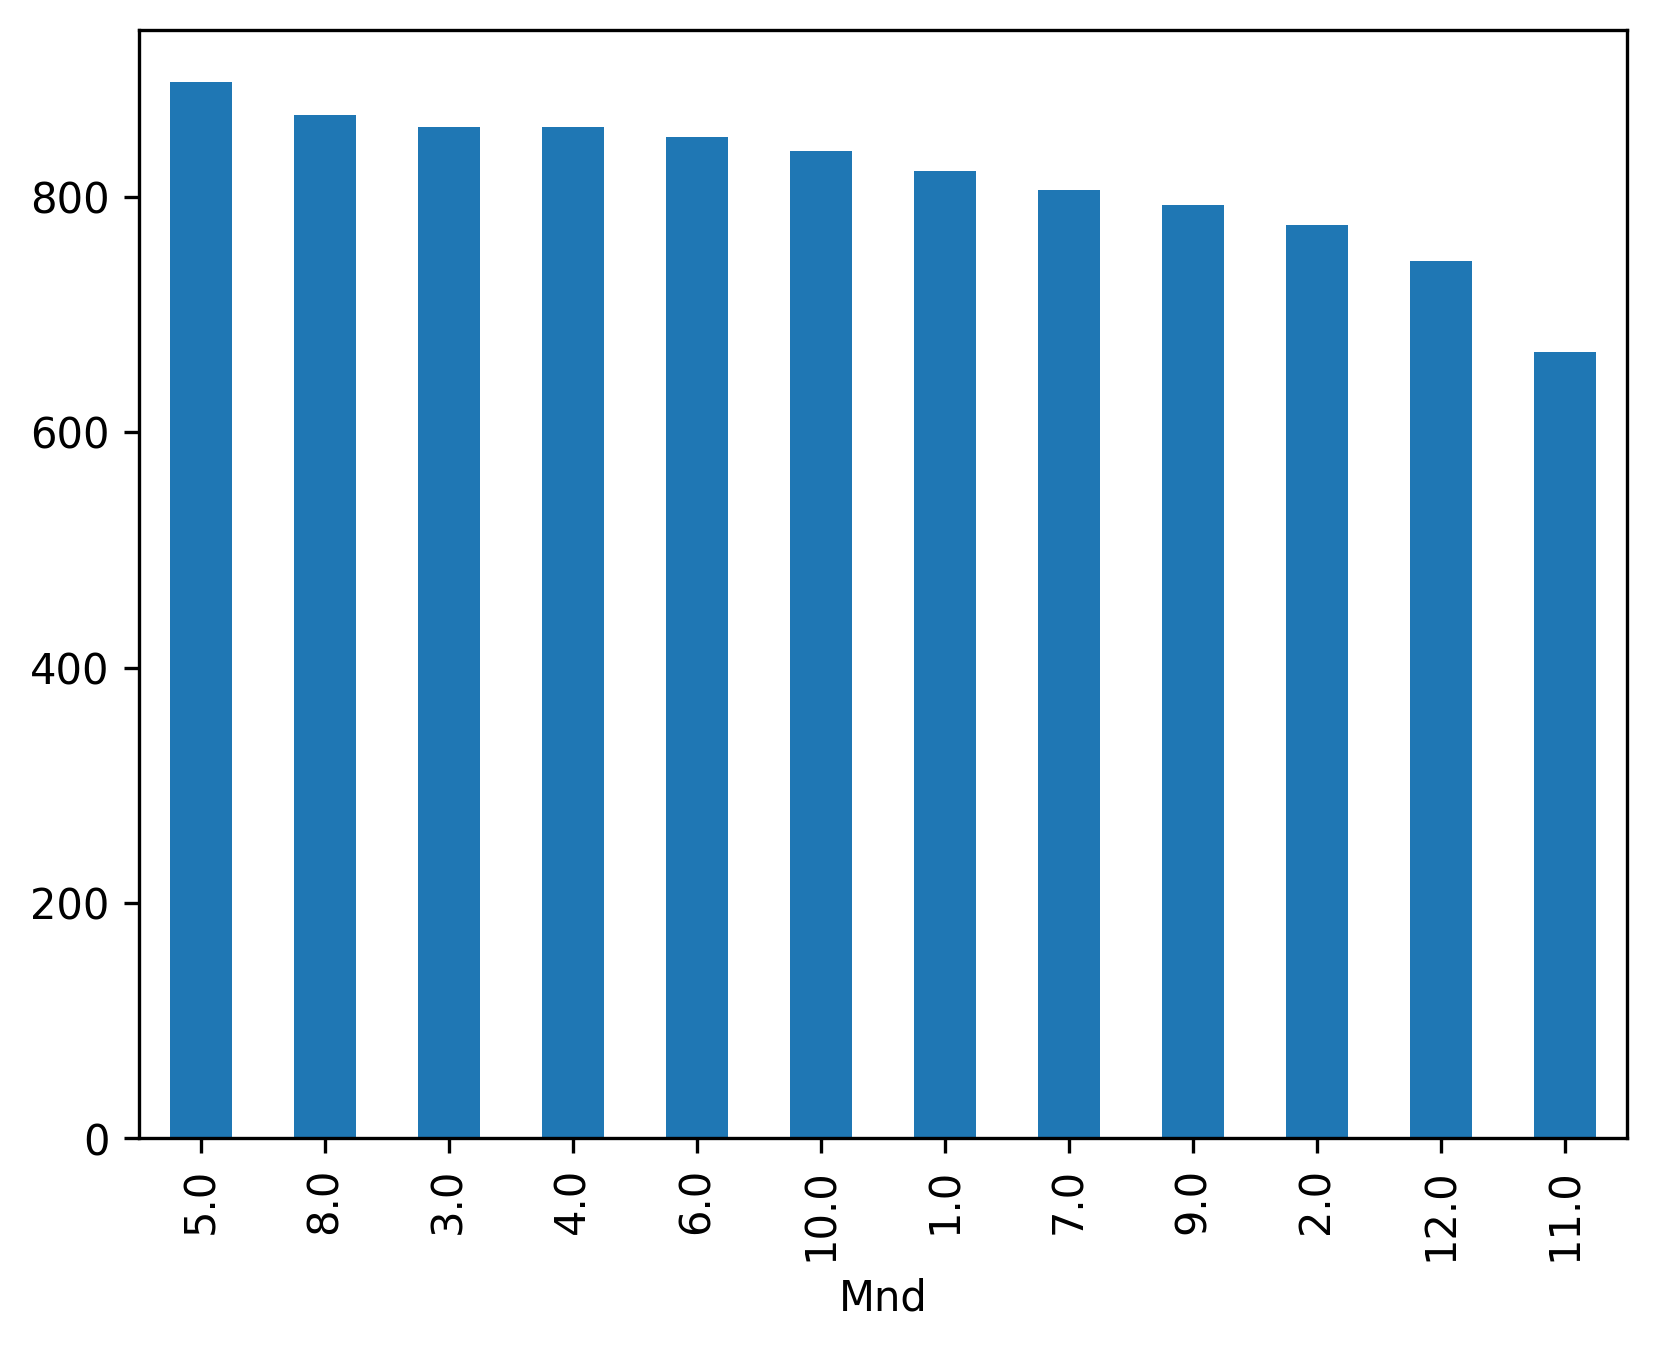

In [20]:
df_triage_t["Mnd"].value_counts().plot(kind='bar')

<Axes: xlabel='Season'>

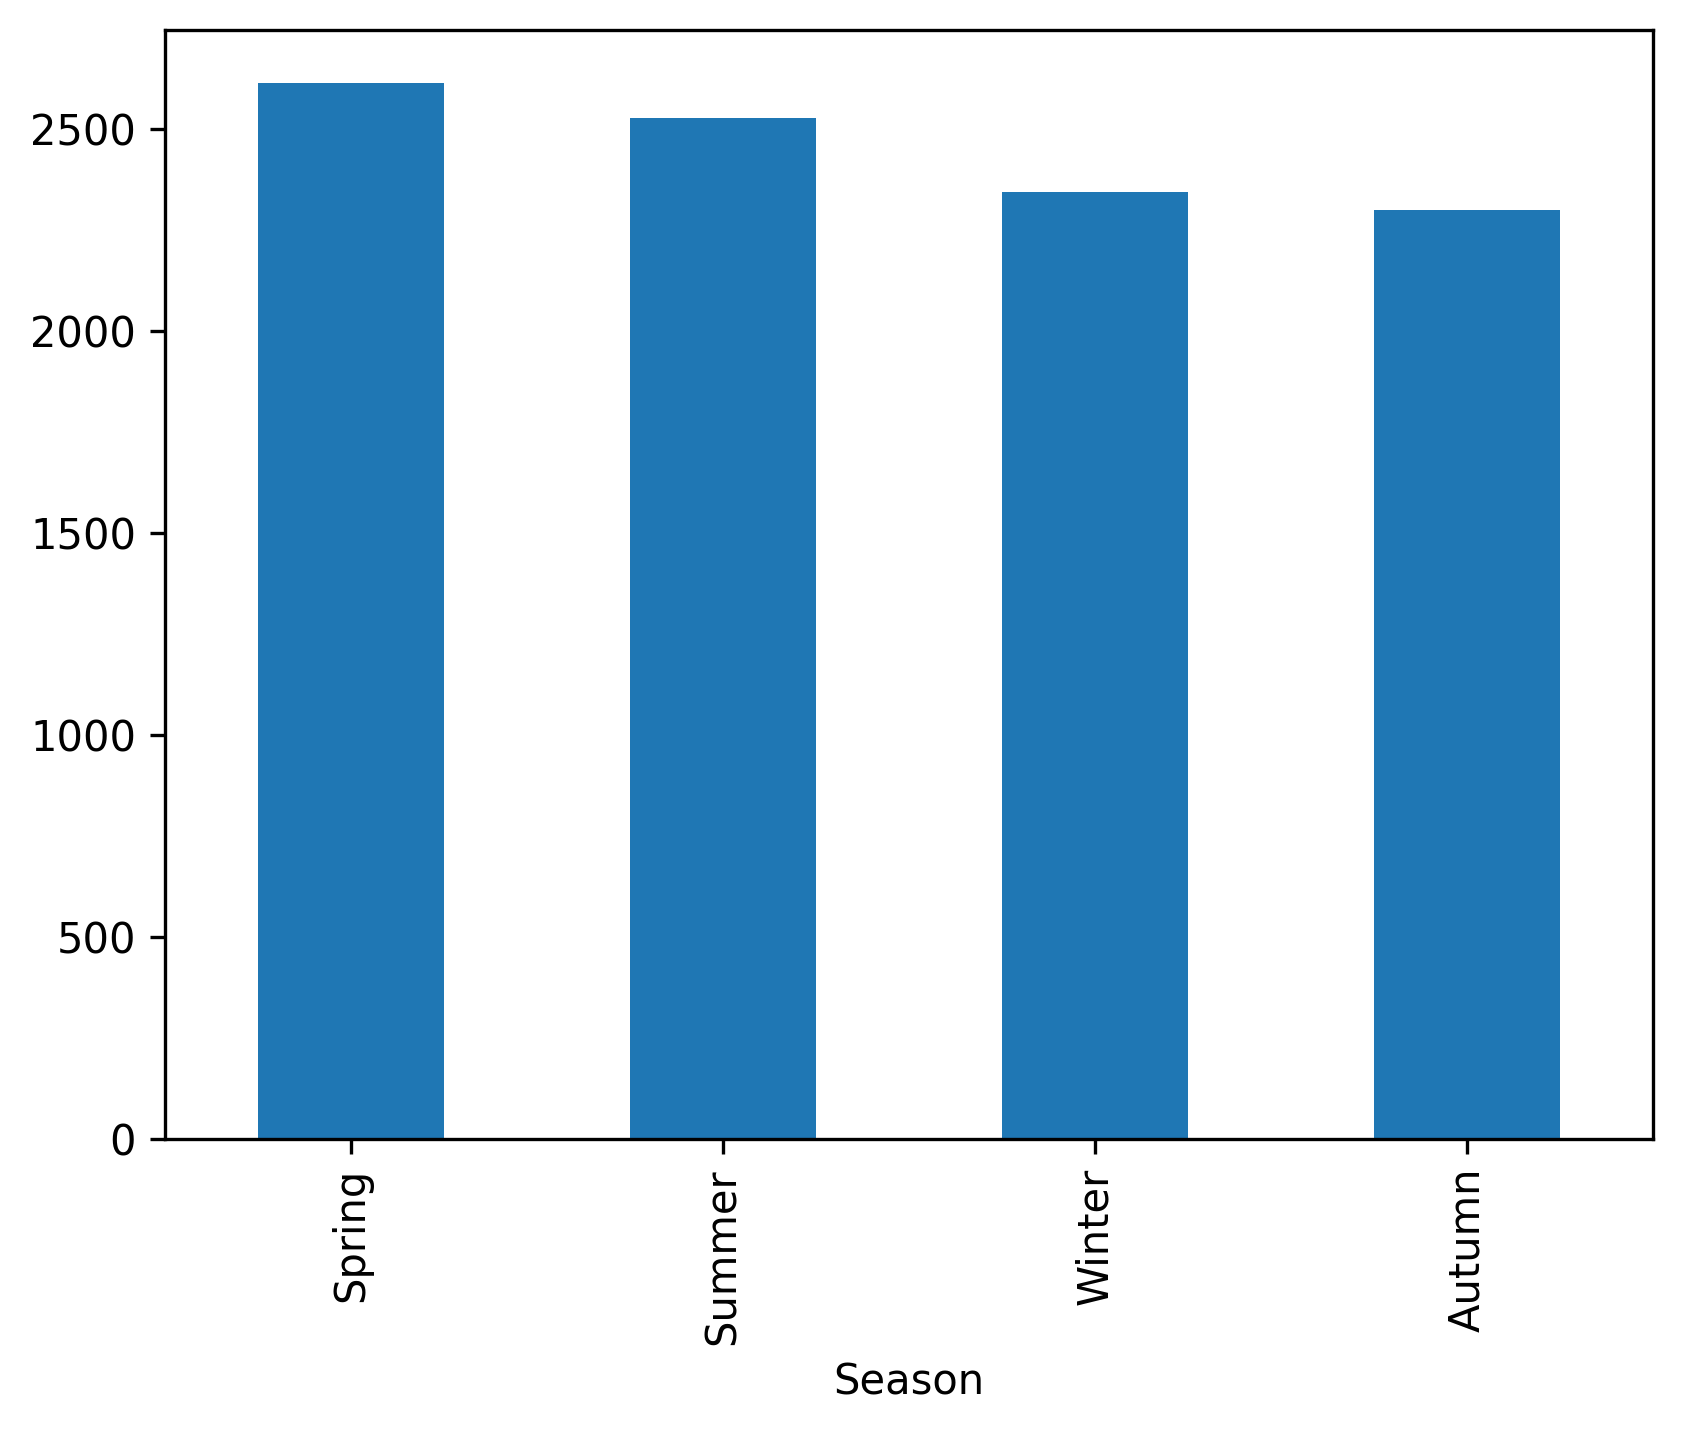

In [21]:
season_month_north = {
            12.0:'Winter', 1.0:'Winter', 2.0:'Winter',
            3.0:'Spring', 4.0:'Spring', 5.0:'Spring',
            6-0:'Summer', 7.0:'Summer', 8.0:'Summer',
            9.0:'Autumn', 10.0:'Autumn', 11.0:'Autumn'}
df_triage_t["Season"] = df_triage_t.Mnd.map(season_month_north)
df_triage_t["Season"].value_counts().plot(kind='bar')

### Admission Time

In [22]:


df_triage_t.Time_in= pd.to_datetime(df_triage_t.Time_in)
#df_triage_t.Time_out= pd.to_datetime(df_triage_t.Time_out)

/tmp/ipykernel_928855/2950131872.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_triage_t.Time_in= pd.to_datetime(df_triage_t.Time_in)


In [23]:

df_triage_t['Time_in_h']=df_triage_t.Time_in.dt.strftime('%H')


In [24]:
for c in df_triage_t.select_dtypes(include='object'):
    df_triage_t[c] = df_triage_t[c].astype('string')
#df_triage_t[categorical_features].info()
df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9784 entries, 35 to 205185
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Phtriage           5238 non-null   float64       
 1   Htriage            9784 non-null   int64         
 2   Dischgto           9784 non-null   string        
 3   Dischhome          9784 non-null   int64         
 4   DischICU           9784 non-null   int64         
 5   EMRGgroup          9784 non-null   string        
 6   Time_in            9784 non-null   datetime64[ns]
 7   Time_out           9783 non-null   string        
 8   EDLOS              9773 non-null   float64       
 9   Kjonn              9784 non-null   string        
 10  InICD10-code       8177 non-null   string        
 11  InICD10-chapter    9784 non-null   string        
 12  Aar                9784 non-null   float64       
 13  Mnd                9784 non-null   float64       
 14  DOW       

<Axes: xlabel='AdmtimeGrp'>

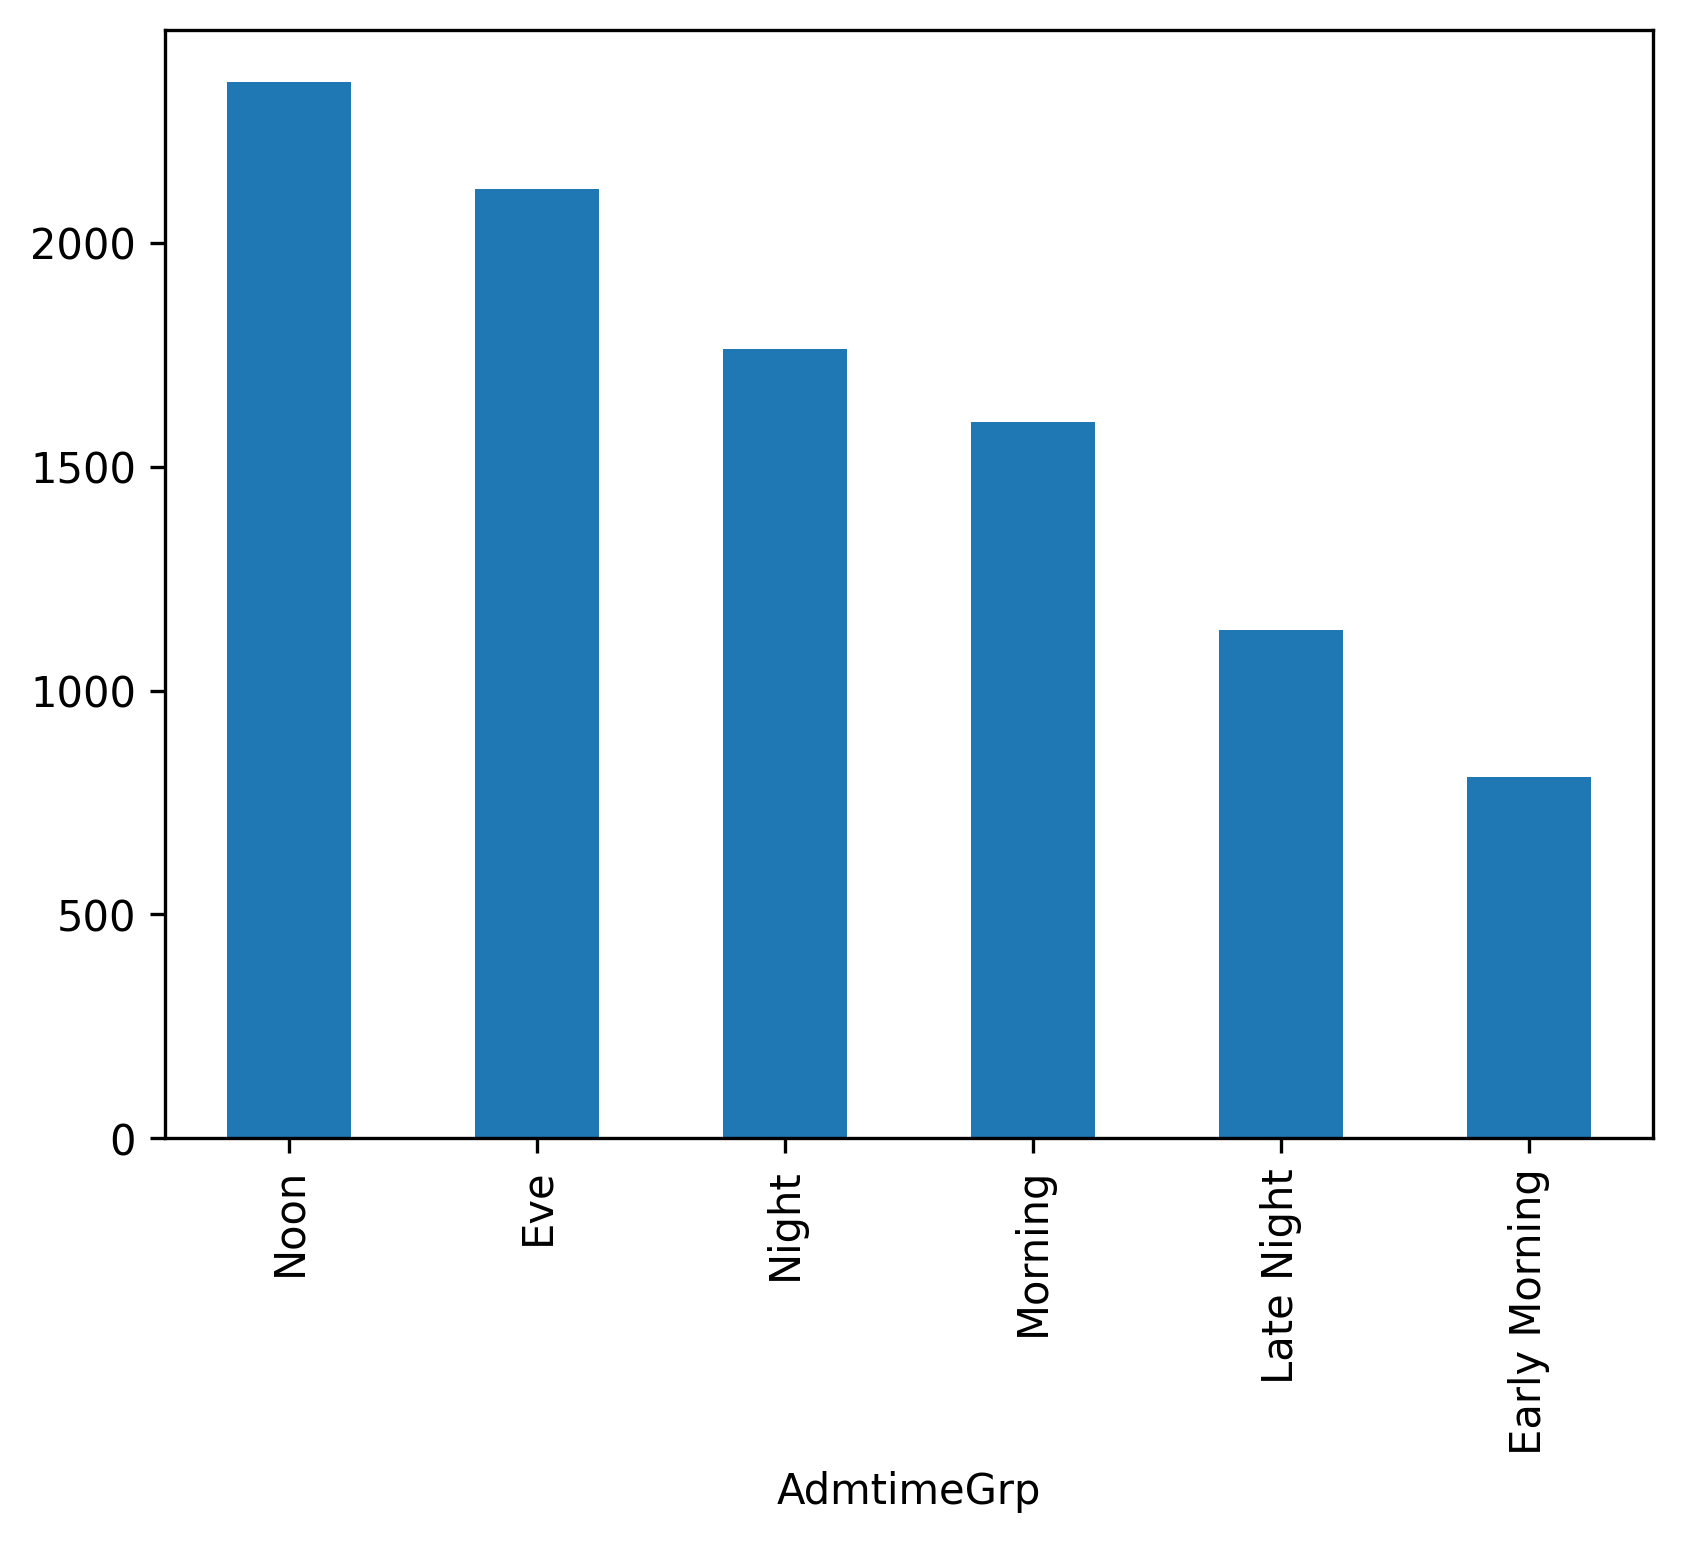

In [25]:
df_triage_t['Admtime']= df_triage_t.Time_in_h.astype(float).astype(int)
#df_triage_t=df_triage_t.loc[df_triage_t.Age>=18]
bins =  [0,4,8,12,16,20,24]
labels = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
df_triage_t['AdmtimeGrp'] = pd.cut(df_triage_t.Admtime, bins, labels = labels,right=False)
#df_triage_t["AgeGrp"] = df_triage_t.AgeGrp.map({'0-12':0,'13-17':1, '20-64':2, '65+':3})
#df_triage_t["AgeGrpDesc"] = df_triage_t.AgeGrp.map({'0-12':'Children','13-17':'Teen', '18-64':'Adult', '65+':'Older'})
df_triage_t['AdmtimeGrp'].value_counts().plot(kind='bar')

## Classification and SHAP values

In [26]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import xgboost as xgb

import shap
random_state = np.random.RandomState(0)
shap.initjs()

In [27]:
features = ['HtriageGrp' ,
             # 'Dischgto'
            # 'Dischhome',
            #'DischICU',
            'EMRGgroup',
        'Kjonn'#, 'InICD10-chapter',
          #  'Aar' correlated to triagestmt
        #    'Mnd',
    #'Season',
      # 'DOW', #'Shift',# 'nprDiagn', 'Out_ICD10-chapter',
         ,   'AgeGrp',
          #  '24hmrt',
      # '7dmrt', '30dmrt',
        #    'Triagestm',
           'AdmtimeGrp'
      # ,'Time_in_m'#, 'Time_out_h', 'Time_out_m'
           ]
nominal_features=[#'Dischgto',
                  #'Dischhome'#, 'DischICU'
                  'EMRGgroup','AdmtimeGrp'
        'Kjonn'#,  'InICD10-chapter',
     #  'DOW', # 'nprDiagn', 'Out_ICD10-chapter',
    '24hmrt'#,'Season'
     #  ,'7dmrt', '30dmrt'
]
ordinal_features=[ #'HtriageGrp',
          #        'Aar'
                   #'Mnd',
      'AgeGrp', #'Time_in_h'# 'Time_in_h'#'Triagestm'
     # 'Shift'#, 'Time_in_m',
       #'Time_out_h', 'Time_out_m'
                 ]

In [28]:
data = df_triage_t[features]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9784 entries, 35 to 205185
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   HtriageGrp  9784 non-null   int64   
 1   EMRGgroup   9784 non-null   string  
 2   Kjonn       9784 non-null   string  
 3   AgeGrp      9483 non-null   category
 4   AdmtimeGrp  9784 non-null   category
dtypes: category(2), int64(1), string(2)
memory usage: 325.4 KB


In [29]:
#load data
data = df_triage_t[features]

#get features
y = data['HtriageGrp']
y = y.astype('category').cat.codes
X_cat = data.drop('HtriageGrp', axis=1)

In [30]:
#fit encoder
enc = OneHotEncoder()
enc.fit(X_cat)

#transform categorical features
X_encoded = enc.transform(X_cat).toarray()

#create feature matrix
feature_names = X_cat.columns
new_feature_names = enc.get_feature_names_out(feature_names)

X = pd.DataFrame(X_encoded, columns= new_feature_names)

## Choosing a model by StratisfiedKfold and GridSearch


In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

In [32]:
def model_train(model,X, y, param,smote=True):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=11)
    sm = SMOTE()
    if smote == True:
        #pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
         #                               ['scaler', MinMaxScaler()],
          #                              ['classifier', model]])


        X_train, y_train = sm.fit_resample(X_train, y_train)

    #else:
        #smote = SMOTE(random_state = 11)
        #X_train, y_train = smote.fit_resample(X_train, y_train)
        #pipeline = Pipeline(steps = [['scaler', MinMaxScaler()],
                                     #['classifier', model]])


    stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)


    param_grid = param
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='roc_auc',
                               cv=stratified_kfold,
                               n_jobs=-1)


    grid_search.fit(X_train, y_train)
    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    return {'clf':grid_search,'model':type(model).__name__,'SMOTE':smote,'cv_score':cv_score, 'test_score':test_score}

In [33]:
model = LogisticRegression(random_state=11, max_iter=1000)
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
model_dict = model_train(model,X,y,param_grid,True)
model_lr_smote = model_dict['clf']
model_dict

{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=LogisticRegression(max_iter=1000, random_state=11),
              n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
              scoring='roc_auc'),
 'model': 'LogisticRegression',
 'SMOTE': True,
 'cv_score': 0.7764464417936654,
 'test_score': 0.7773923125173524}

In [34]:
model = LogisticRegression(random_state=11, max_iter=1000,class_weight="balanced")
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
model_dict = model_train(model,X,y,param_grid,False)
model_lr = model_dict['clf']
model_dict

{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=LogisticRegression(class_weight='balanced',
                                           max_iter=1000, random_state=11),
              n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
              scoring='roc_auc'),
 'model': 'LogisticRegression',
 'SMOTE': False,
 'cv_score': 0.7570369858248533,
 'test_score': 0.7786194031129712}

In [35]:
model =RandomForestClassifier(n_estimators=150, random_state=0)
param_grid = {'n_estimators': [200, 500],
    'max_features': [None,'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
model_dict = model_train(model,X,y,param_grid,True)
model_rf_smote = model_dict['clf']
model_dict

{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=RandomForestClassifier(n_estimators=150, random_state=0),
              n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [4, 5, 6, 7, 8],
                          'max_features': [None, 'sqrt', 'log2'],
                          'n_estimators': [200, 500]},
              scoring='roc_auc'),
 'model': 'RandomForestClassifier',
 'SMOTE': True,
 'cv_score': 0.851143789312707,
 'test_score': 0.7875757934100437}

In [36]:
from sklearn.utils import class_weight
# A array object that contains the weights for both classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
# A dictionary object containing key-value pairs of both classes and # their weights
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

model =RandomForestClassifier(n_estimators=150, random_state=0,class_weight=class_weights_dict)
param_grid = {'n_estimators': [200, 500],
    'max_features': [ None,'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
model_dict = model_train(model,X,y,param_grid,False)
model_rf = model_dict['clf']
model_dict

{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=RandomForestClassifier(class_weight={0: 0.5962218159658744,
                                                             1: 3.0981633945535147},
                                               n_estimators=150,
                                               random_state=0),
              n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [4, 5, 6, 7, 8],
                          'max_features': [None, 'sqrt', 'log2'],
                          'n_estimators': [200, 500]},
              scoring='roc_auc'),
 'model': 'RandomForestClassifier',
 'SMOTE': False,
 'cv_score': 0.7598727317848992,
 'test_score': 0.7839493636609802}

In [37]:
model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    )

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
        
        'gamma':  [i/10.0 for i in range(3)],
        
        'colsample_bytree': [i/10.0 for i in range(1, 3)],
        'max_depth': range(3, 10)
        }
model_dict = model_train(model,X,y,param_grid,True)
model_xgb_smote = model_dict['clf']
model_dict


{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False, eval_metric=None,
                                      feature_types=None, gamma=None,
                                      grow_policy=None, importance_typ...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=600,
                                      n_jobs=None, num_parallel_tree=None,
                                  

In [38]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y
)

model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    )

param_grid = {'scale_pos_weight' : class_weights,
    'n_estimators': [50, 100, 150, 200,],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
        
        'gamma':  [i/10.0 for i in range(3)],
        
        'colsample_bytree': [i/10.0 for i in range(1, 3)],
        'max_depth': range(3, 10)
        }
model_dict = model_train(model,X,y,param_grid,False)
model_xgb = model_dict['clf']
model_dict


{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False, eval_metric=None,
                                      feature_types=None, gamma=None,
                                      grow_policy=None, importance_typ...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=600,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=None, ...),
              n_jobs=-1,
              param_grid

In [39]:
model =  DecisionTreeClassifier(random_state=1024)
        

param_grid = {'max_features': [None ,'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
model_dict = model_train(model,X,y,param_grid,True)
model_dt_smote = model_dict['clf']
model_dict



{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=DecisionTreeClassifier(random_state=1024), n_jobs=-1,
              param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [5, 6, 7, 8, 9],
                          'max_features': [None, 'sqrt', 'log2']},
              scoring='roc_auc'),
 'model': 'DecisionTreeClassifier',
 'SMOTE': True,
 'cv_score': 0.80120316886495,
 'test_score': 0.7667786643907222}

In [40]:
model =  DecisionTreeClassifier(random_state=1024,class_weight="balanced")
        

param_grid = {'max_features': [None ,'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
model_dict = model_train(model,X,y,param_grid,False)
model_dt = model_dict['clf']
model_dict



{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=DecisionTreeClassifier(class_weight='balanced',
                                               random_state=1024),
              n_jobs=-1,
              param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [5, 6, 7, 8, 9],
                          'max_features': [None, 'sqrt', 'log2']},
              scoring='roc_auc'),
 'model': 'DecisionTreeClassifier',
 'SMOTE': False,
 'cv_score': 0.7552422054846657,
 'test_score': 0.7722680096110671}

In [41]:

X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=11)

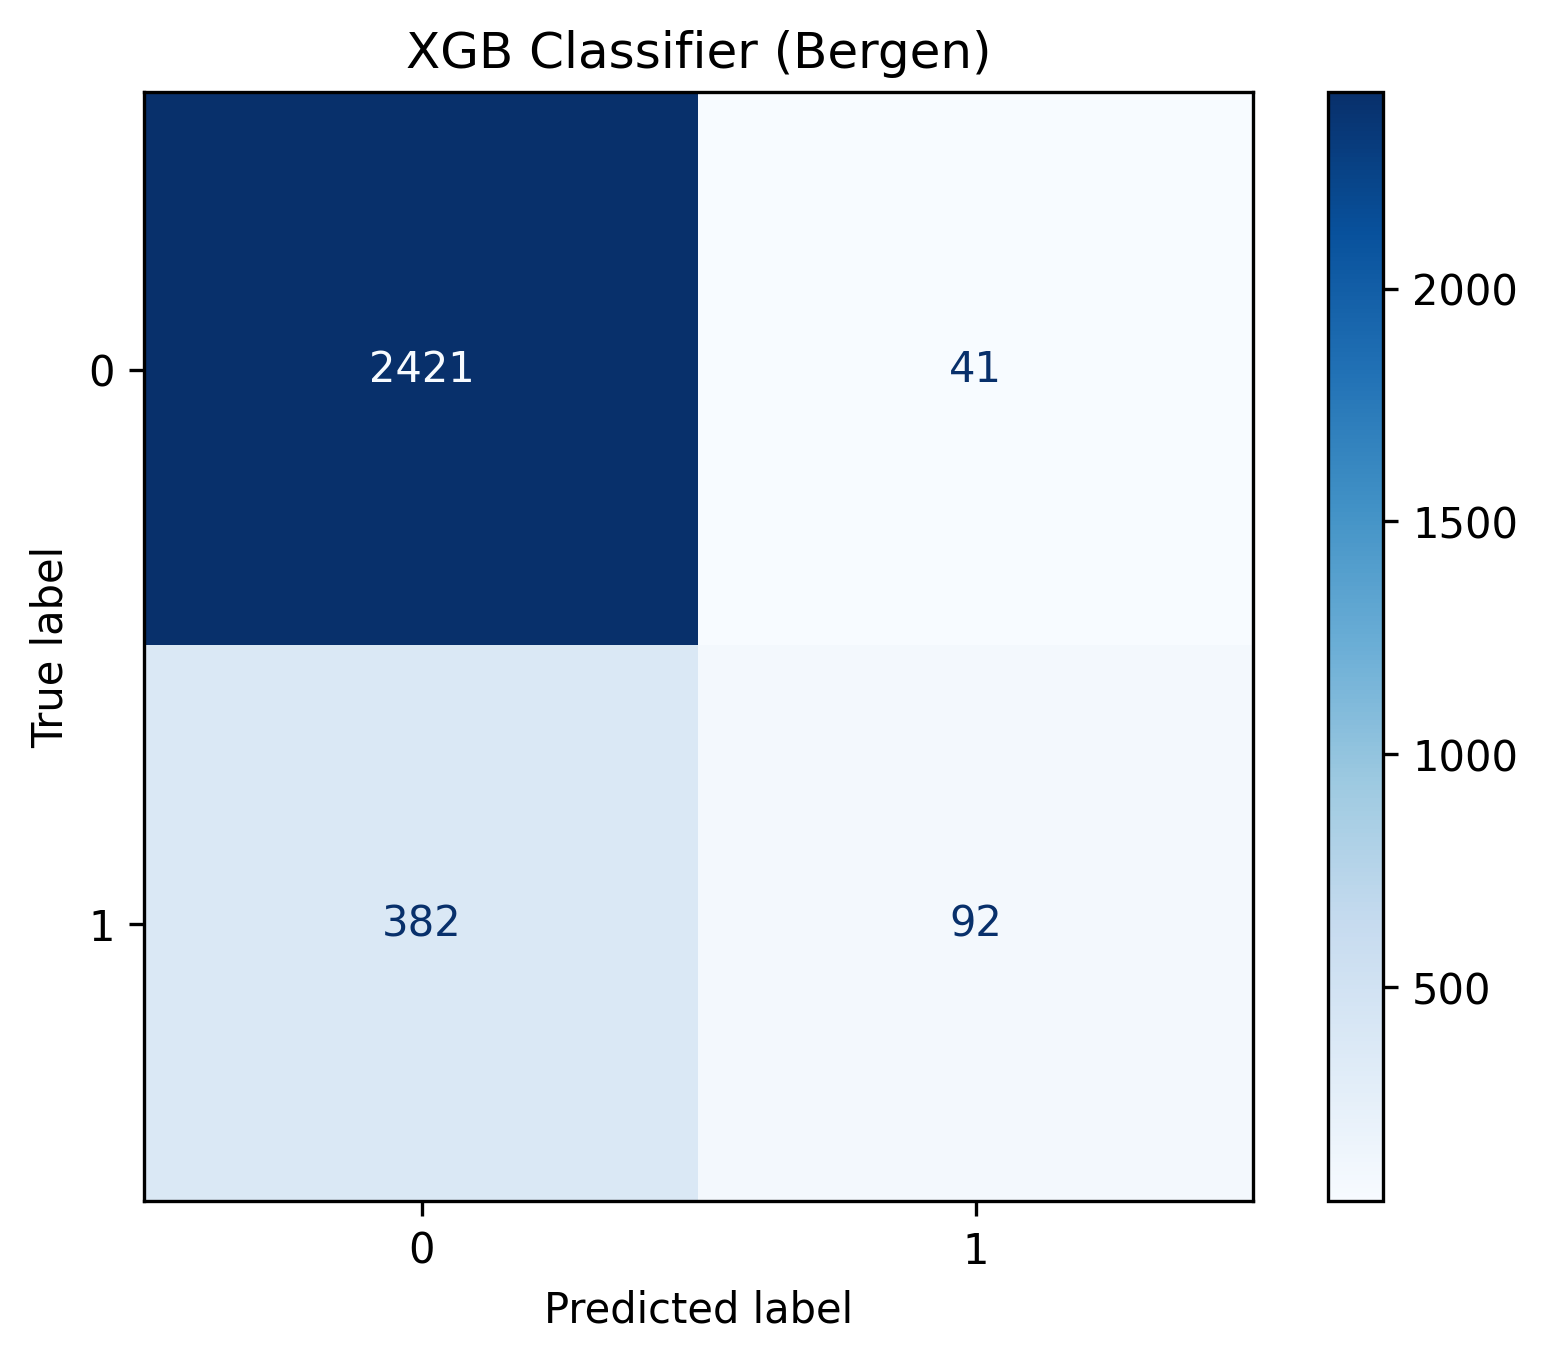

In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,PrecisionRecallDisplay


y_pred = model_xgb.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test,
                                             y_pred,

                                             #display_labels=target_names,
                                             cmap=plt.cm.Blues,
                                             normalize=None
                                            )
    #disp = PrecisionRecallDisplay.from_predictions(y_test, predictions_train[i],name=i)

#plt.title(i)
    #print(cm)
    #print(classification_report(y_test, predictions_test[i]),'\n')
plt.title('XGB Classifier (Bergen)')
plt.show()

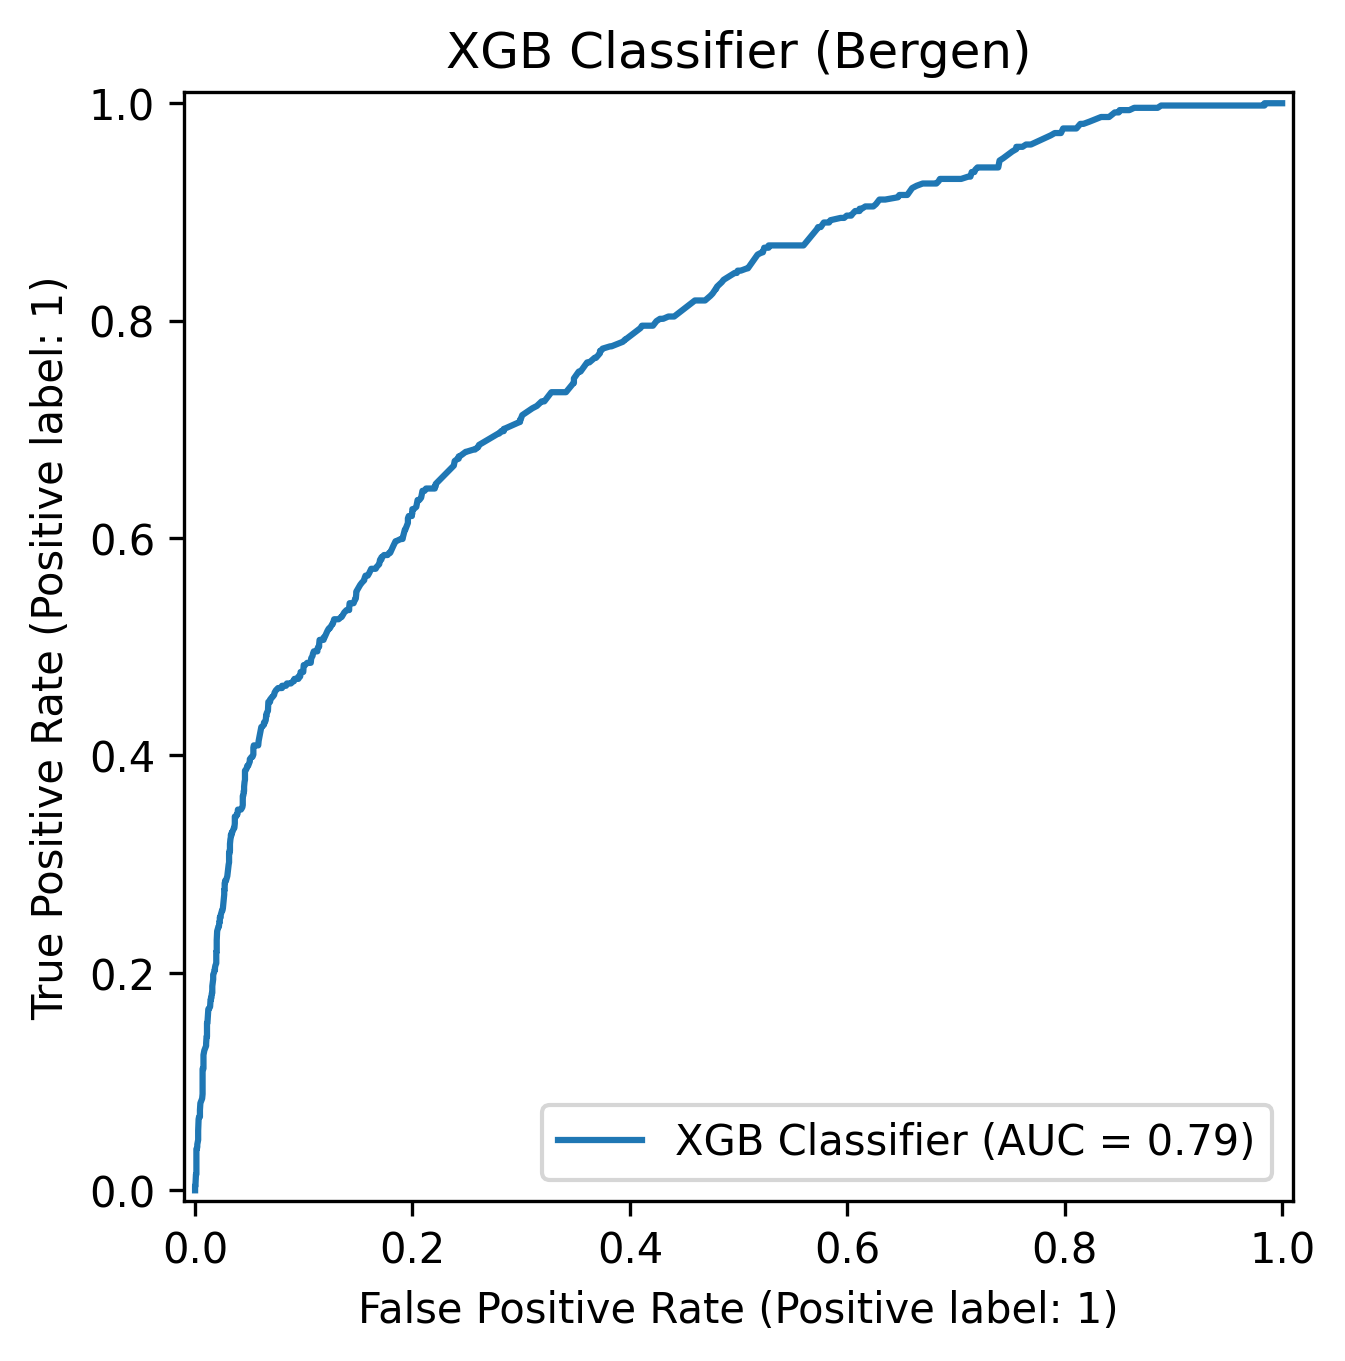

In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,RocCurveDisplay


    
y_pred = model_xgb.predict_proba(X_test)[:,1]

disp = RocCurveDisplay.from_predictions(y_test, y_pred,name="XGB Classifier")    #disp = PrecisionRecallDisplay.from_predictions(y_test, predictions_train[i],name=i)

#plt.title(i)
    #print(cm)
    #print(classification_report(y_test, predictions_test[i]),'\n')
plt.title('XGB Classifier (Bergen)')
plt.show()

### Standard SHAP values

In [56]:
# get shap values
#pip = clf.models['XGBClassifier']
model = model_xgb.best_estimator_
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

### SHAP for categorical features

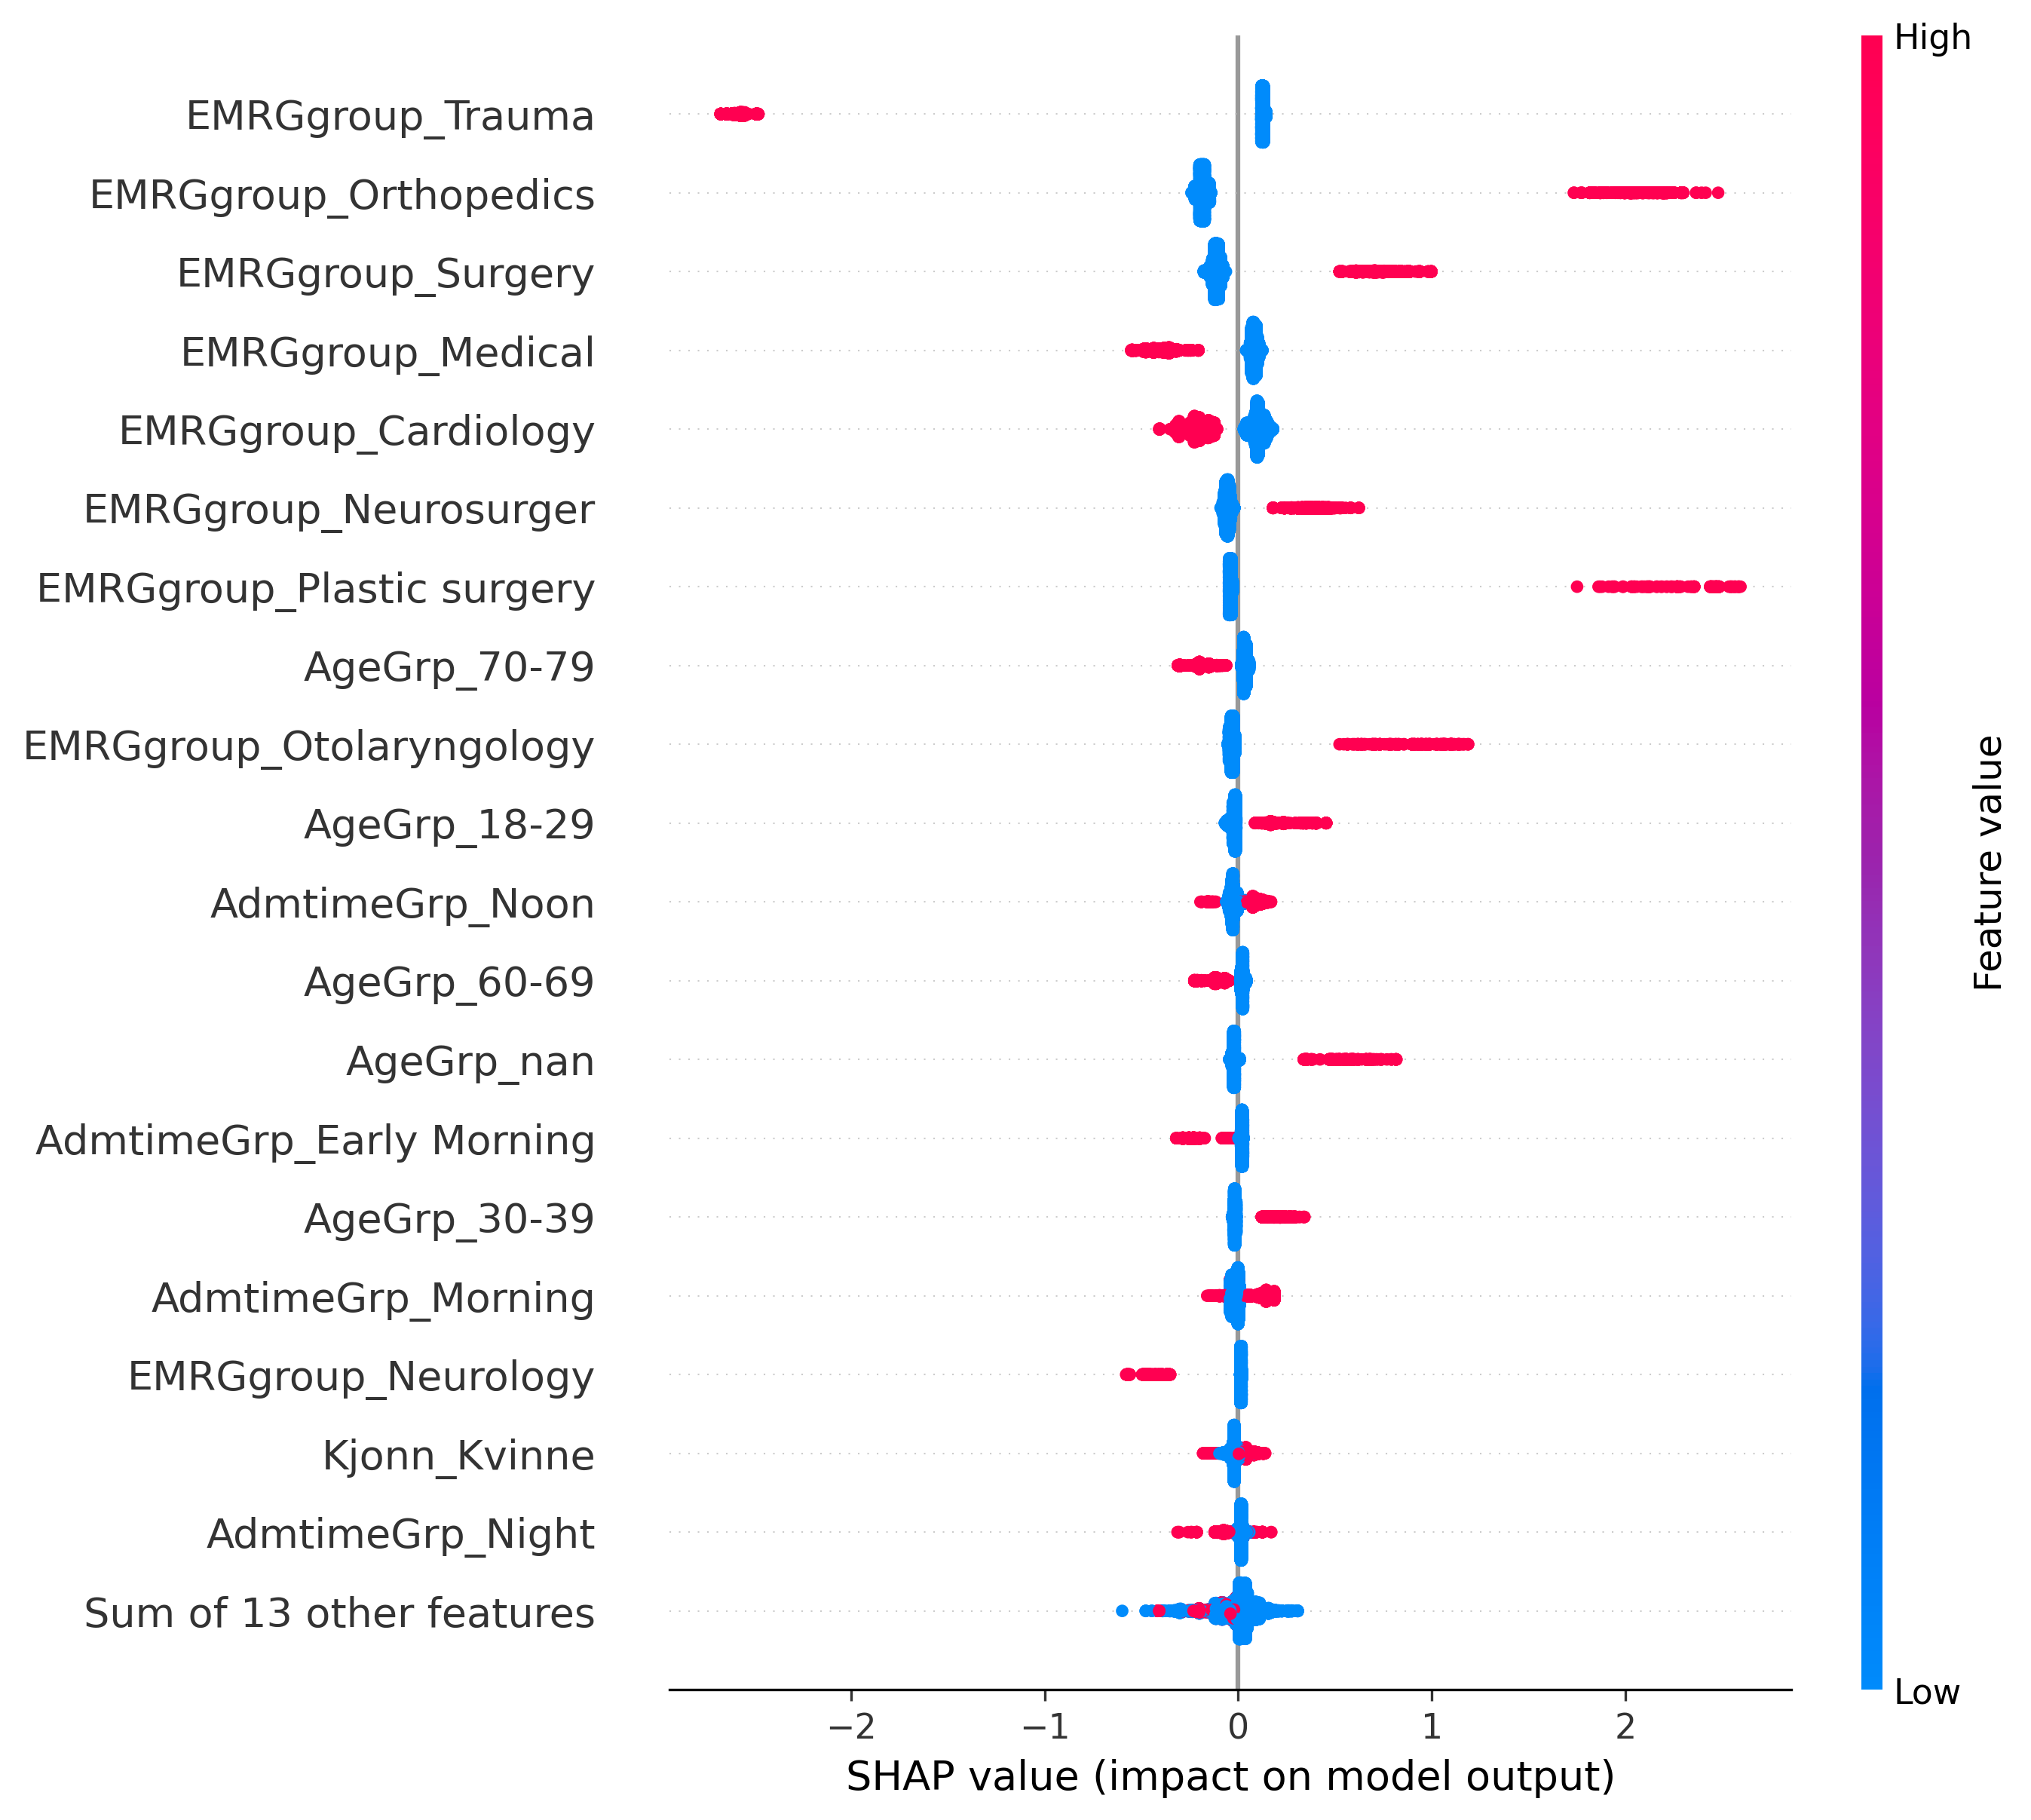

In [58]:
#Mean SHAP
shap.plots.beeswarm(shap_values, max_display=20)
#shap.summary_plot(shap_values, X_test, plot_type="bar")

add the SHAP values for each categorical feature together.

In [46]:
feature_names

Index(['EMRGgroup', 'Kjonn', 'AgeGrp', 'AdmtimeGrp'], dtype='object')

In [47]:
#get number of unique categories for each feature
n_categories = []
for feat in feature_names:
    n = X_cat[feat].nunique()
    n_categories.append(n)
n_categories

[12, 3, 10, 6]

In [48]:
import math

new_shap_values = []
for values in shap_values.values:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    #print(values_split)
    #sum values within each list
    values_sum = [math.fsum(l) for l in values_split]
    
    new_shap_values.append(values_sum)
np.shape(new_shap_values)

(9784, 5)

In [49]:

#replace shap values
shap_values.values = np.array(new_shap_values)

#replace data with categorical feature values 
new_data = np.array(X_cat)
shap_values.data = np.array(new_data)

#update feature names
shap_values.feature_names = list(X_cat.columns)

the InICD10-Chapter A And lack of other Diagnoses has increased the log odds
the EMRGgroup MED A And lack of other Diagnoses has increased the log odds

Text(0.5, 1.08, '(A) Bergen ')

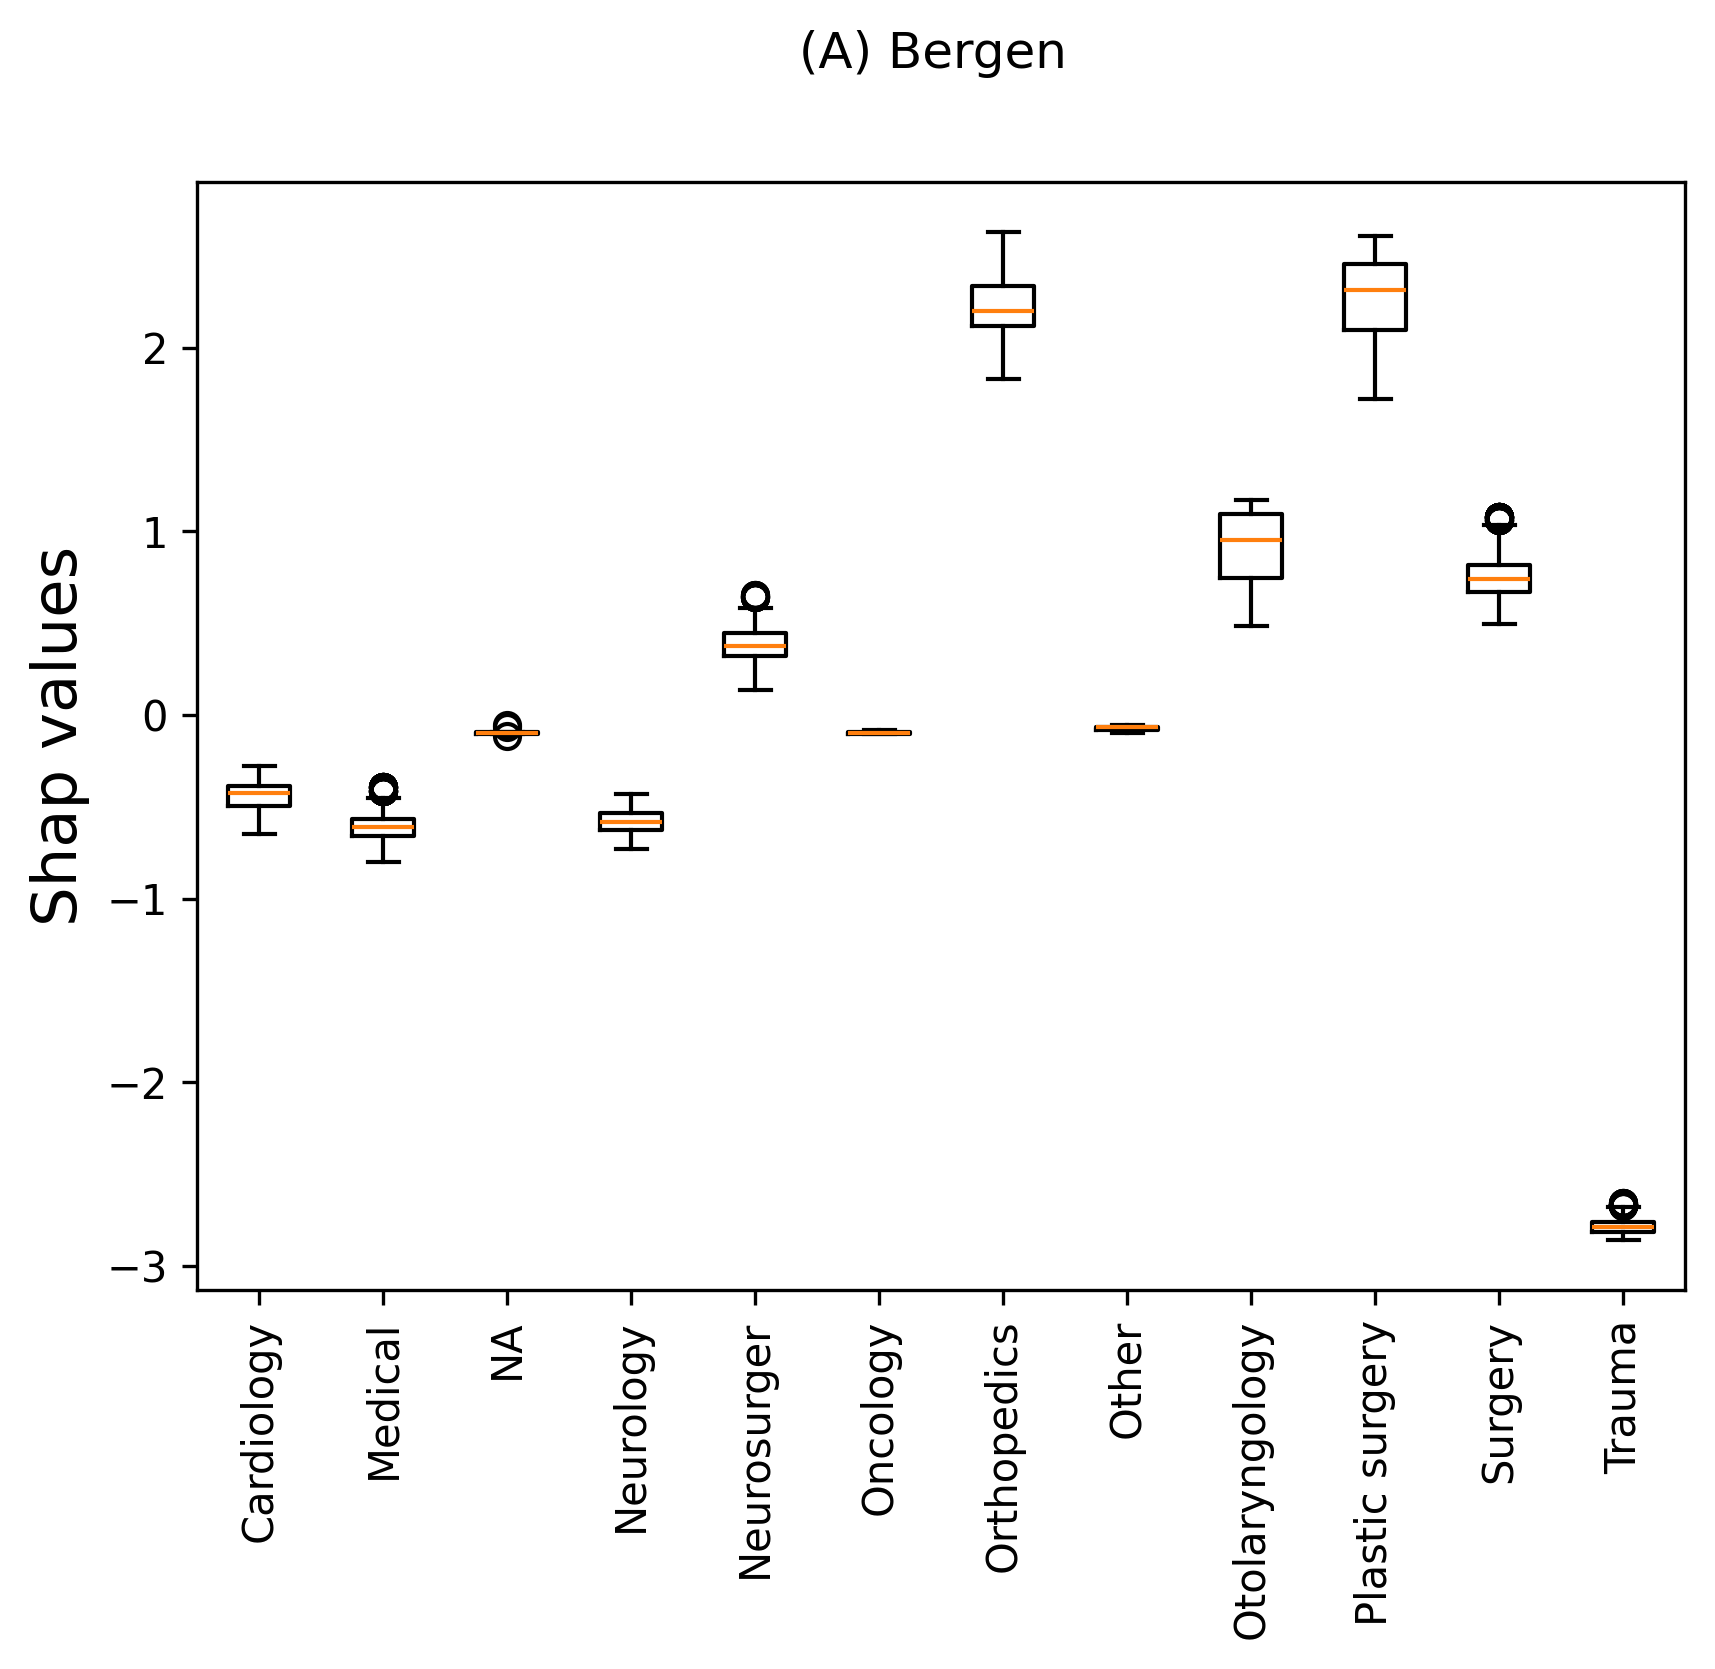

In [50]:
#split EMRGgroup shap values based on EMRGgroup values

emrg_values = shap_values[:,0].values
emrg_data = shap_values[:,0].data
emrg_categories = sorted(list(set(emrg_data)), key=str.lower)

emrg_groups = []
for o in emrg_categories:
    relevant_values = emrg_values[emrg_data == o]
    emrg_groups.append(relevant_values)


labels =emrg_categories
#labels= [Emrg_labels[u] for u in emrg_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)

plt.boxplot(emrg_groups,labels=labels,manage_ticks=True)


plt.ylabel('Shap values',size=15)
#plt.xlabel('Emergency_Group',size=15)
plt.title('(A) Bergen ', y=1.08)

Text(0.5, 1.08, '(A) Bergen ')

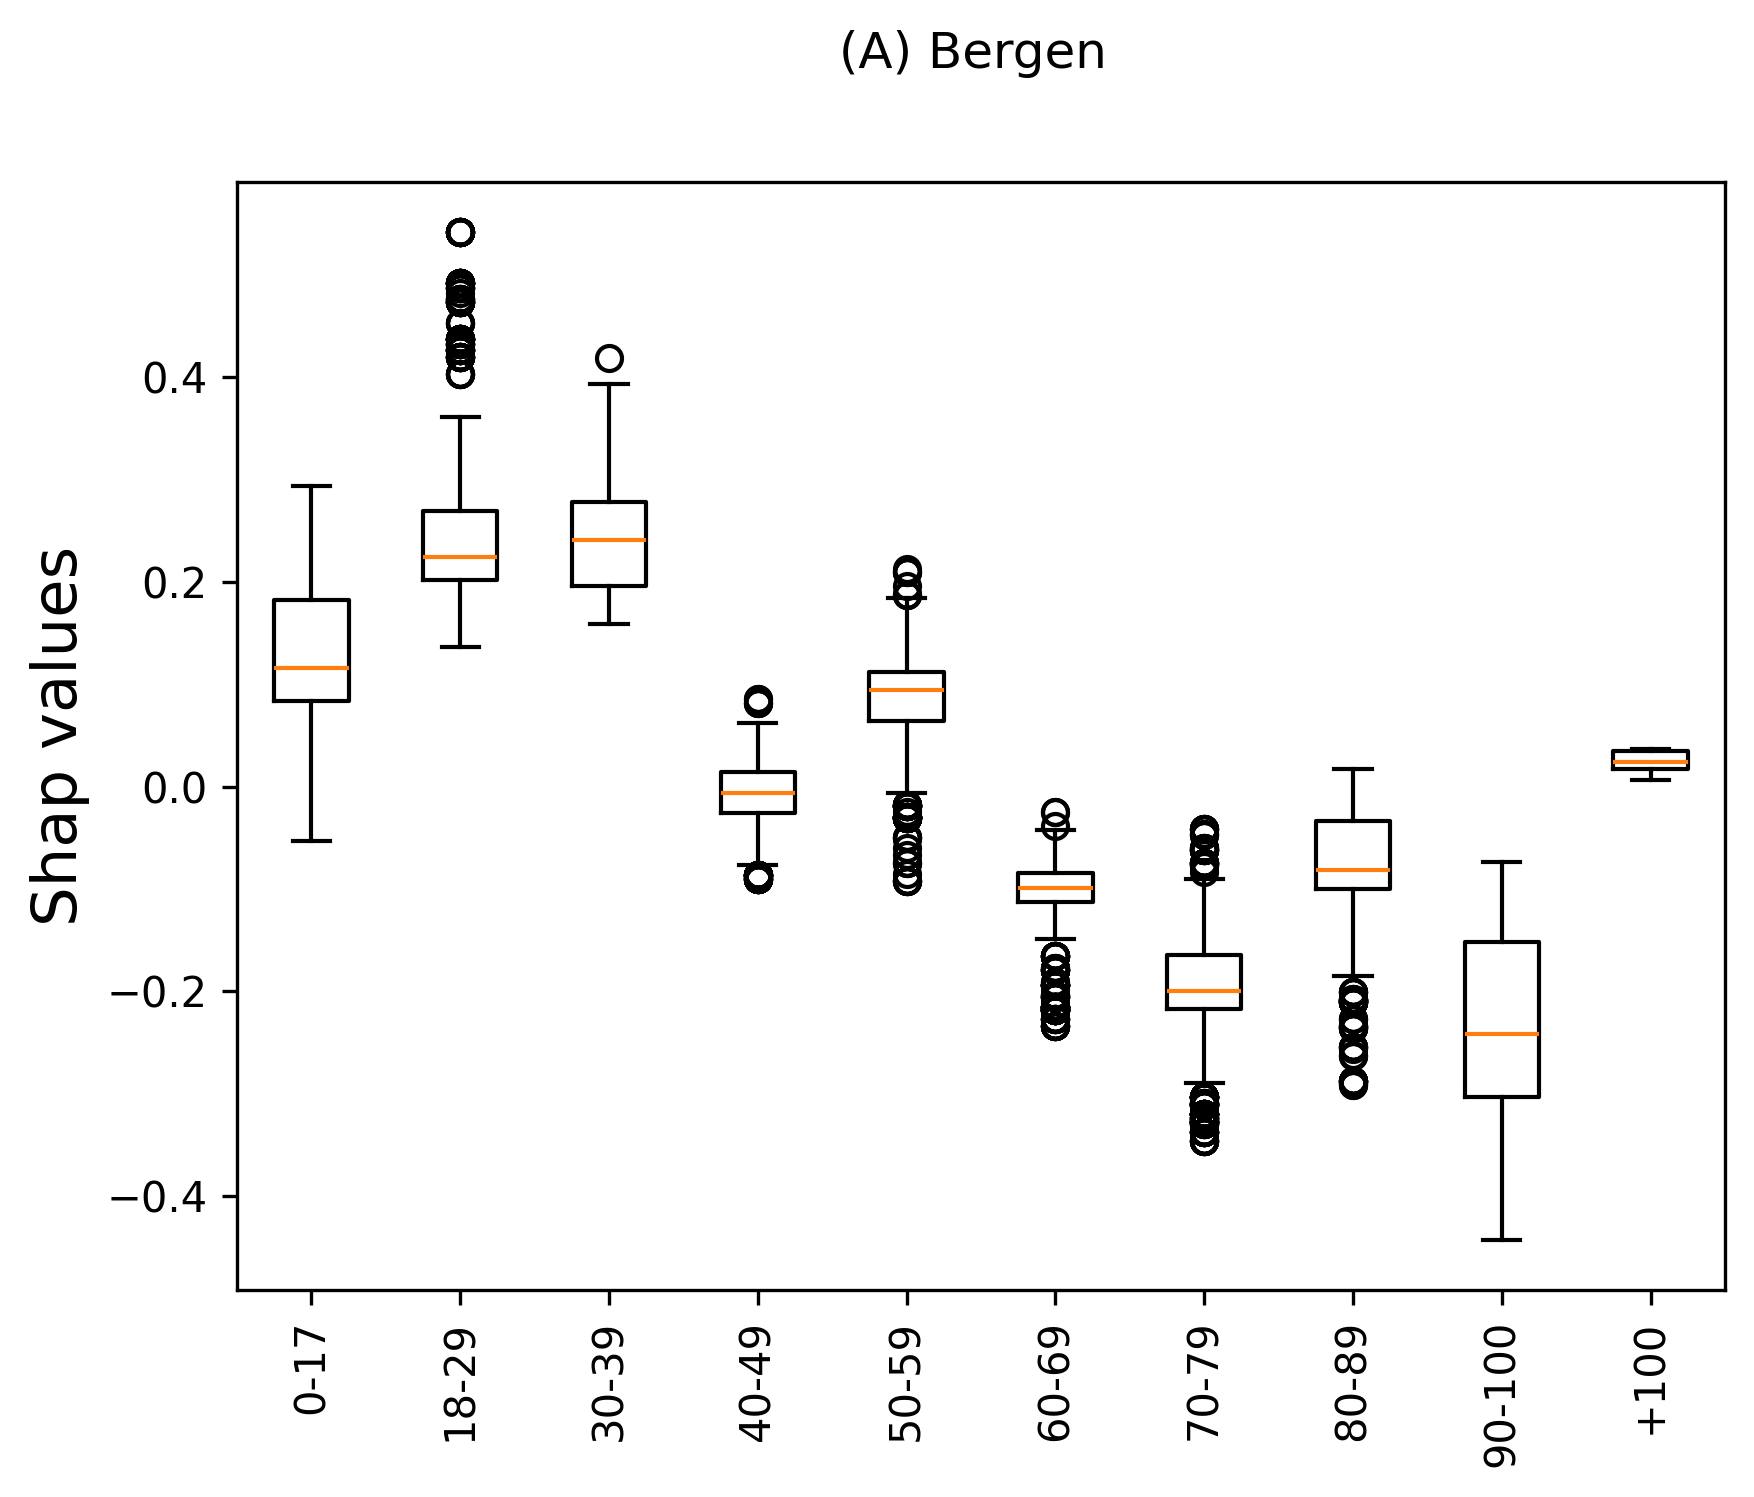

In [51]:
#split AgeGrp shap values based on  individual AgeGrp values

age_values = shap_values[:,2].values
age_data = shap_values[:,2].data
age_categories = list(set(age_data))
#print(age_categories)
age_categories = ['0-17','18-29', '30-39', '40-49', '50-59', '60-69', '70-79','80-89','90-100','+100']
age_groups = []
for o in age_categories:
    relevant_values = age_values[age_data == o]

    age_groups.append(relevant_values)


labels = age_categories
#labels= [ageGrp_labels[u] for u in ageGrp_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)

plt.boxplot(age_groups,labels=labels,manage_ticks=True)
#ax.set(xticklabels=labels)
#sns.boxplot(data=ageGrp_groups,order=columns_my_order)

#plt.boxplot(ageGrp_groups,labels=labels)

plt.ylabel('Shap values',size=15)
#plt.xlabel('AgeGroup',size=15)
plt.title('(A) Bergen ', y=1.08)

Text(0.5, 1.08, '(A) Bergen ')

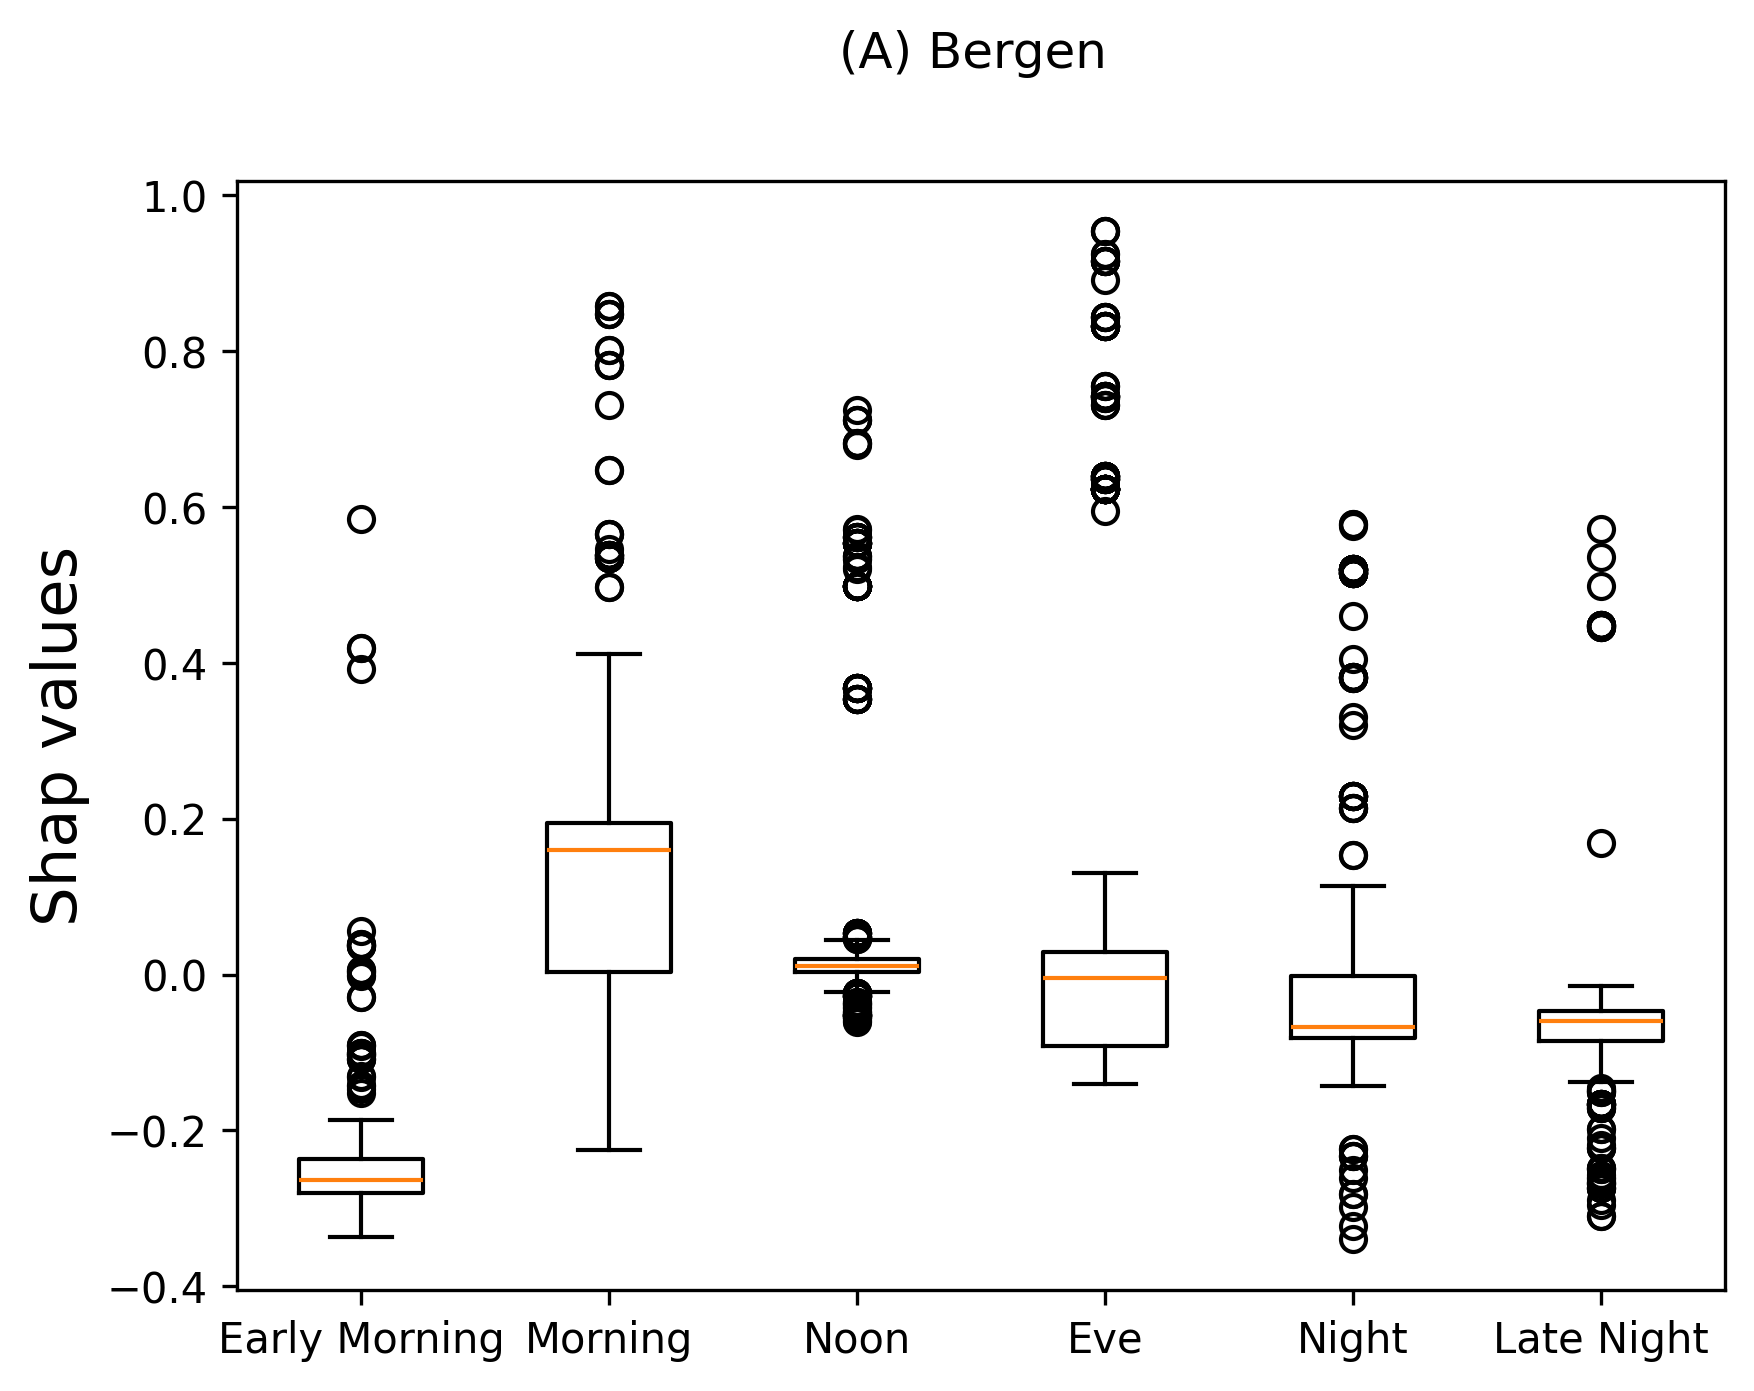

In [52]:
#split AdmtimeGrp shap values based on  individual AdmtimeGrp values

timeinH_values = shap_values[:,3].values
timeinH_data = shap_values[:,3].data
#timeinH_categories = list(set(timeinH_data))

timeinH_groups = []
timeinH_categories=['Early Morning','Morning', 'Noon',   'Eve','Night', 'Late Night']
for o in timeinH_categories:
    relevant_values = timeinH_values[timeinH_data == o]
    timeinH_groups.append(relevant_values)

#replace categories with labels


labels = timeinH_categories
#labels= [timeinH_labels[u] for u in timeinH_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))

plt.boxplot(timeinH_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.title('(A) Bergen ', y=1.08)

Text(0.5, 1.08, '(A) Bergen ')

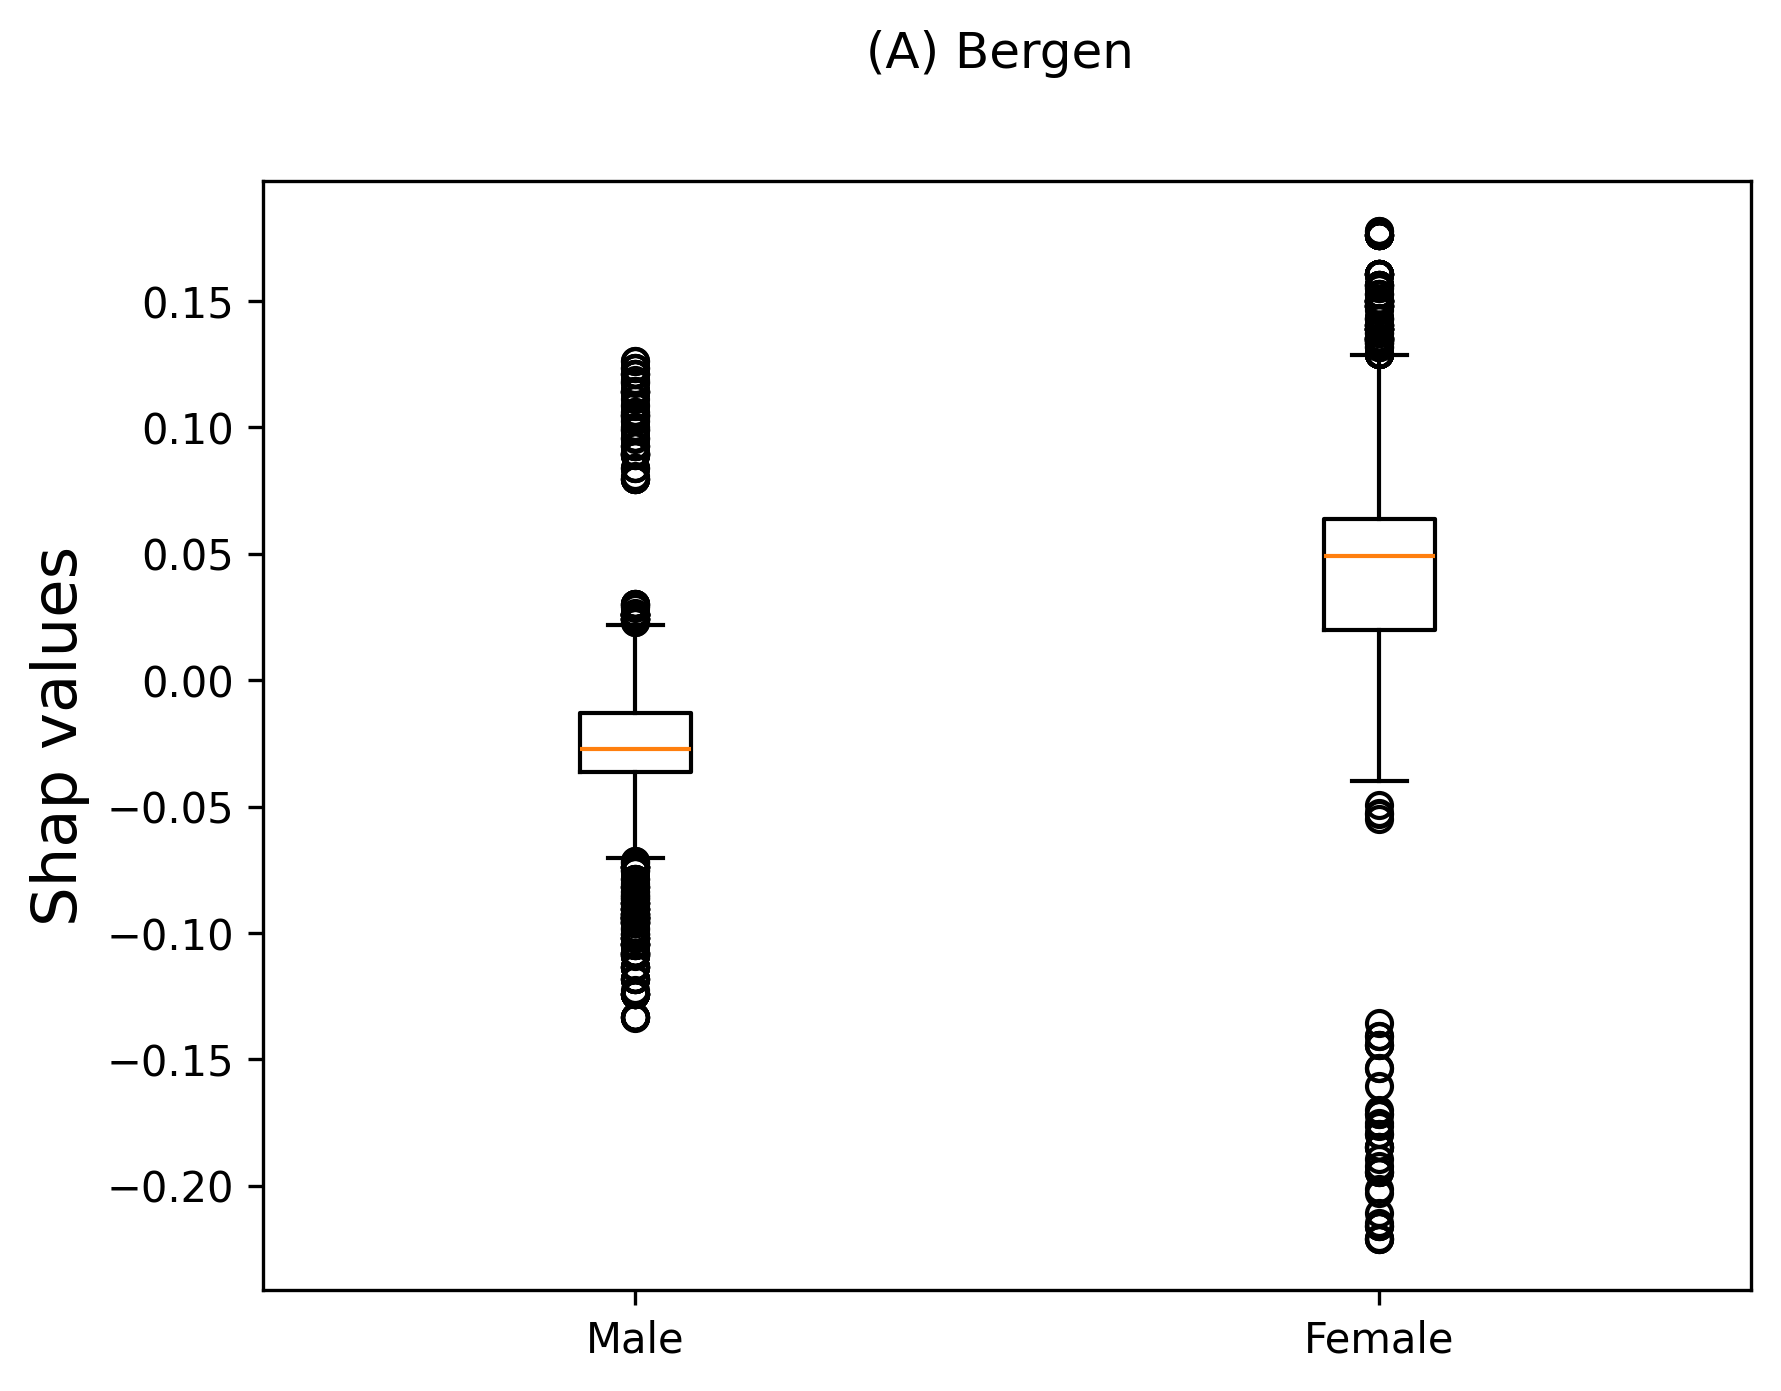

In [53]:
#split Sex shap values based on  individual Sex values

Kjonn_values = shap_values[:,1].values
Kjonn_data = shap_values[:,1].data
Kjonn_categories = ['Mann','Kvinne']#list(set(Kjonn_data))

Kjonn_groups = []
for o in Kjonn_categories:
    relevant_values = Kjonn_values[Kjonn_data == o]
    Kjonn_groups.append(relevant_values)

#replace categories with labels
Kjonn_labels = {'Kvinne':'Female',
                'Mann':'Male',
                'missing':'Missing'






              }

labels = Kjonn_categories
labels= [Kjonn_labels[u] for u in Kjonn_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))

plt.boxplot(Kjonn_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.title('(A) Bergen ', y=1.08)